# Importing Packages Needed

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
from scipy.interpolate import UnivariateSpline
import glob 

# Definition of Named Tuples

In [2]:
subpulse = col.namedtuple('subpulse','phase intensity')
ind_sub = col.namedtuple('ind_sub','phase intensity width')
pulse_sub = col.namedtuple('pulse_sub','frequency sub1 mid1 mid2 sub2, errors')
pulse_fits = col.namedtuple('pulse_fits','thorsett, powerlaw, linear')
one_fit = col.namedtuple('one_fit','params, errors, cov, chir')
pl_av = col.namedtuple('pl_av', 'frequency, phase')

# Definition of Functions

Functions needed to calculate chi squared values and find error in pulse data

In [3]:
def chsq(observed_values, expected_values, err):
    """
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

In [4]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

Gaussian Fitting Functions:

In [5]:
"""
Definitions of gaussian equations. 
"""
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

"""
Fitting data into the above gaussian equations. Number of gaussians is dependent on expected value and bounds.
"""
def multi_fit(x, y, error, expect, bound):
    params,cov=curve_fit(multi_gauss,x,y,expect,bounds=bound)
    fit=multi_gauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-len(params))
    
    return params, cov, fit, chir

In [6]:
"""
    Creates a four gaussian fit for the full frequency scrunched data.
    Uses the peak of data to creat an expected value, attempts a fit, and if the chi squared reduced is below 1.1
    it returns the fit.
""" 

def fitting_ave_gaussians(x,y, error):   
    #Finding peak of the data
    mx=max(y)
    yl=list(y)
    mx_ind=yl.index(mx)
    mx_ph=x[mx_ind]
    
    #Attempts to use the peak of the data as an expected value, if it is in the correct range
    if mx_ph>profile_peak1-plus_minus_range and mx_ph<profile_peak1+plus_minus_range:
        expect=[mx,mx_ph,10, 15,profile_peak2-25,5,15,profile_peak2+25,5, 25,profile_peak3,10]
    elif mx_ph>profile_peak3-plus_minus_range and mx_ph<profile_peak3+plus_minus_range:
        expect=[25,profile_peak1,10,15,profile_peak2-25,5,15,profile_peak2+25,5, mx,mx_ph,10]
    else:
        expect=[25,profile_peak1,10,15,profile_peak2-25,5,15,profile_peak2+25,5,25,profile_peak3,10]

    bound=([0,0,0,0,profile_peak2-125,0,0,profile_peak2-125,0,0,profile_peak3-plus_minus_range,0],[np.inf,profile_peak1+plus_minus_range,30,np.inf,profile_peak2+50,30,np.inf,profile_peak2+50,30,np.inf,np.inf,30])
    
    #Trys to create a four gaussian fit
    try:
        params, cov, fit, chir = multi_fit(x, y, error, expect, bound)
        sigma=np.sqrt(np.diag(cov))
    except Exception as e:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0
        print('Fit = 0 - No fit created')
    
    #If the data has a chi squared reduced above 1.1 then don't use the pulse
    #if chir>1.1:
        #print('Fit = 0 - Chi too high', chir)
        #params=0
        #fit=[]
        #chir=5000
        #sigma=0
        #cov=0  
        
        
    return fit, params, sigma, cov, chir

In [7]:
"""
    Based off the parameters of the fitting on the frequency scrunched profile, it creates an expected value for gaussian fits.
    Detects how many peaks are above 15 intensity, and that is the number of expected gaussians.
    If the maximum peak has a signal to noise less than 3.5, don't include this pulse. 
""" 
def find_expected(ax,ay,aerror):
    #Find the gaussian fit on the frequency scrunched profile
    fit, params, sigma, cov, chir=fitting_ave_gaussians(ax,ay, aerror)
    expect=[]
    
    if fit!=[]:
        #Find the peaks of the fit
        minima,maxima,mine,maxe=find_minima_maxima_gauss(params, cov, len(ax))
        maxy=multi_gauss(maxima,*params)
        peaks=[]
        peaky=[]
        #Only include profiles where the max peak has a signal/noise greater than 3.5
        if (max(maxy)/aerror)>3.5:
            for i in range(len(maxima)):
                #Only include peaks which are greater than 15
                if maxy[i]>15:
                    expect.extend([(maxy[i]+5),maxima[i],5])
                    peaks.append(maxima[i])
                    peaky.append(maxy[i])
    if expect==[]:
        print('F scrunched pulse too noisey')
          
    return expect

In [8]:
"""
    Creates a gaussian fit for the data based on the expected value gained from the full frequency scrunched profile.
""" 
def fitting_gaussians(x,y, error, expect):   
    #Only includes frequency bands with error smaller than 30
    if error<30 and expect!=[]:
        #Attempts to use the peak of the data as an expected value, if it is in the correct range
        mx=max(y)
        yl=list(y)
        mx_ind=yl.index(mx)
        mx_ph=x[mx_ind]
        if mx_ph>profile_peak1-plus_minus_range and mx_ph<profile_peak1+plus_minus_range:
            expect[0]=mx
        elif mx_ph>profile_peak3-plus_minus_range and mx_ph<profile_peak3+plus_minus_range:
            expect[-3]=mx
        #Assigns the correct bounds, depending on number of gaussians
        bound=([],[])
        for i in range(0, len(expect), 3):
            bound[0].extend([0,0,0])
            bound[1].extend([np.inf,np.inf,30])
        #Attempts to create a fit for the data using the expected and bounds
        try:
            params, cov, fit, chir = multi_fit(x, y, error, expect,bound)
            sigma=np.sqrt(np.diag(cov))
        except:
            params=0
            fit=[]
            chir=5000
            sigma=0
            cov=0 
    else:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0   
    return fit, params, sigma, cov, chir

Finding Peak of Gaussian Fittings Function

In [9]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x
    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    Created by Keegan Smith
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [10]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian
    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

In [11]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all roots of a gaussian function
    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
    
    #Find max and min errors
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [12]:
def gauss_peaksn(fit, nofreqband, freqband, cov, params,freq_low,freq_high,noise):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    #Used to convert phase bins into degrees
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err=find_minima_maxima_gauss(params, cov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    pul1=subpulse(phase=0, intensity=0)
    mi1=subpulse(phase=0, intensity=0)
    mi2=subpulse(phase=0, intensity=0)
    pul2=subpulse(phase=0, intensity=0)
    error=[0,0,0,0]
    
    #Assign the peaks to be either subpulse 1 or 2, or mid 1 or 2, also converts phase from bins to degrees
    if len(peakpos)!=0:
        for i in range(len(peakpos)):
            if peakpos[i]<profile_peak1+plus_minus_range and peakpos[i]>profile_peak1-plus_minus_range and (peakint[i]/noise)>2.5 and peakint[i]>pul1[1]:
                pul1=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[0]=(err[i]*(deg_mod))
            elif peakpos[i]<((profile_peak3-profile_peak1)/2)+profile_peak1 and peakpos[i]>profile_peak1+75 and (peakint[i]/noise)>1.5 and peakint[i]>mi1[1]:
                mi1=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[1]=(err[i]*(deg_mod))
            elif peakpos[i]<profile_peak3-75 and peakpos[i]>((profile_peak3-profile_peak1)/2)+profile_peak1 and (peakint[i]/noise)>1.5 and peakint[i]>mi2[1]:
                mi2=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[2]=(err[i]*(deg_mod))        
            elif peakpos[i]<profile_peak3+plus_minus_range and peakpos[i]>profile_peak3-plus_minus_range and (peakint[i]/noise)>2.5 and peakint[i]>pul2[1]:
                pul2=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[3]=(err[i]*(deg_mod))

    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low
    profile_comp = pulse_sub(frequency=freq, sub1=pul1, mid1=mi1, mid2=mi2, sub2=pul2, errors=error)

    return profile_comp

Plotting Fittings Functions

In [13]:
"""
    Used to make different plots of the fits, their components and peaks.
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot((360/1024)*x,y, lw=0.5)
    py.plot((360/1024)*x, fit, color='red', lw=3, label='gaussian fit')

    x=[]
    y=[]
    for i in range(1,5):
        if profile_comp[i][0]!=0:
            x.append(profile_comp[i][0])
            y.append(profile_comp[i][1])

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Finding powerlaw and thorsett fits for data points

In [14]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return (m*np.array(x) +c)

In [15]:
"""
    Attempts to fit a thorsett, power law and linear equation to the data. Also calculates chi squared and reduced 
"""
def three_fits(frequency_comp, phase_comp, comp_err, num): 
    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[100,0.1,0.1]
        elif num==3 or num==4:
            expect=[200,0.01,0.1]
        #Create the thorsett fit
        thorsett_params,thorsett_cov=curve_fit(thorsett,frequency_comp,phase_comp, expect, sigma=comp_err, maxfev=100000)
        thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
        thorsettf = thorsett(frequency_comp, *thorsett_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,thorsettf, comp_err)
        chre=ch/(len(phase_comp)-3)

        thorsett_fit=one_fit(params=thorsett_params, errors=thorsett_fit_error, cov=thorsett_cov, chir=chre)  
    except:
        print('No thorsett for component')
        thorsett_fit=0

    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[100,0.1]
        elif num==3 or num==4:
            expect=[200,0.01]
        #Create the powerlaw fit
        pl_params,pl_cov=curve_fit(powerlaw,frequency_comp,phase_comp,expect, sigma=comp_err, maxfev=100000)
        pl_fit_error=np.sqrt(np.diag(pl_cov))
        powerlawf = powerlaw(frequency_comp, *pl_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,powerlawf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        pl_fit=one_fit(params=pl_params, errors=pl_fit_error, cov=pl_cov, chir=chre)
    except:
        print('No power law for component')
        pl_fit=0

    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[0.05,130]
        elif num==3 or num==4:
            expect=[0.01,230]
        #Create the linear fit
        lin_params,lin_cov=curve_fit(linear,frequency_comp,phase_comp,expect, sigma=comp_err)
        lin_fit_error=np.sqrt(np.diag(lin_cov))
        linearf = linear(np.array(frequency_comp), *lin_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,linearf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        lin_fit=one_fit(params=lin_params, errors=lin_fit_error, cov=lin_cov, chir=chre)
    except:
        print('No linear for component')
        lin_fit=0
        
    pulse_fit=pulse_fits(thorsett=thorsett_fit, powerlaw=pl_fit, linear=lin_fit)
    
    return pulse_fit

In [16]:
def find_fits(fit_spulse,pnum):
    """
    Create the fits for each subpulse 1 through to 4
    """
    sfit1=0
    sfit2=0
    sfit3=0
    sfit4=0
    
    spfig=py.figure(2)
    
    #Find the movement of pulse across frequency for sub pulse 1, converting into graphable arrays
    p1, f1, e1=graphing_spulse(fit_spulse,1)
    #Remove outliers
    if p1!=[]:
        py.errorbar(p1,f1, xerr=e1, fmt='.', color='red', lw=1, label='data')
        py.title('Sub-Pulse 1 -'+pnum)
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        
        f1, p1, e1 = detect_outlier(f1, p1, e1,2)
        
        #Only include if there are 4 or more points, and if their range is no greater than 17
        if len(p1)>3 and (max(p1)-min(p1))<17:
            sfit1=three_fits(f1, p1, e1,1)
            py.errorbar(p1,f1, xerr=e1, fmt='.', color='blue', lw=1, label='data')
            linfit1 = linear(f1, *sfit1[2][0])
            py.plot(linfit1,f1, color='orange',lw=2,label='linear')
            name='single_pulse_fig/'+str(pnum)+ ' - ' + str(int(pnum)-1503960511) +' - Subpulse 1'
            py.savefig(name)
    py.clf()
    
    #Find the movement of pulse across frequency for sub pulse 2, converting into graphable arrays
    p2, f2, e2=graphing_spulse(fit_spulse,2)
    #Remove outliers
    if p2!=[]:
        py.errorbar(p2,f2, xerr=e2, fmt='.', color='red', lw=1, label='data')
        py.title('Sub-Pulse 2 -'+pnum)
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        
        f2, p2, e2 = detect_outlier(f2, p2, e2,2)
        
        #Only include if there are 4 or more points, and if their range is no greater than 10
        if len(p2)>3 and (max(p2)-min(p2))<10:
            sfit2=three_fits(f2, p2, e2,2)
            py.errorbar(p2,f2, xerr=e2, fmt='.', color='blue', lw=1, label='data')
            linfit2 = linear(f2, *sfit2[2][0])
            py.plot(linfit2,f2, color='orange',lw=2,label='linear')
            name='single_pulse_fig/'+str(pnum)+ ' - ' + str(int(pnum)-1503960511) +' - Subpulse 2'
            py.savefig(name)
    py.clf()
            
    #Find the movement of pulse across frequency for sub pulse 3, converting into graphable arrays
    p3, f3, e3=graphing_spulse(fit_spulse,3)
    #Remove outliers
    if p3!=[]:
        py.errorbar(p3,f3, xerr=e3, fmt='.', color='red', lw=1, label='data')
        py.title('Sub-Pulse 3 -'+pnum)
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        
        f3, p3, e3 = detect_outlier(f3, p3, e3,2)
        
        #Only include if there are 4 or more points, and if their range is no greater than 10
        if len(p3)>3 and (max(p3)-min(p3))<10:
            sfit3=three_fits(f3, p3, e3,3)
            py.errorbar(p3,f3, xerr=e3, fmt='.', color='blue', lw=1, label='data')
            linfit3 = linear(f3, *sfit3[2][0])
            py.plot(linfit3,f3, color='orange',lw=2,label='linear')
            name='single_pulse_fig/'+str(pnum)+ ' - ' + str(int(pnum)-1503960511) +' - Subpulse 3'
            py.savefig(name)
    py.clf()

    #Find the movement of pulse across frequency for sub pulse 4, converting into graphable arrays
    p4, f4, e4=graphing_spulse(fit_spulse,4)
    #Remove outliers
    if p4!=[]:
        py.errorbar(p4,f4, xerr=e4, fmt='.', color='red', lw=1, label='data')
        py.title('Sub-Pulse 4 -'+pnum)
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        
        f4, p4, e4 = detect_outlier(f4, p4, e4, 2)
        
        #Only include if there are 4 or more points, and if their range is no greater than 5
        if len(p4)>3 and (max(p4)-min(p4))<5:
            sfit4=three_fits(f4, p4, e4,4)
            py.errorbar(p4,f4, xerr=e4, fmt='.', color='blue', lw=1, label='data')
            linfit4 = linear(f4, *sfit4[2][0])
            py.plot(linfit4,f4, color='orange',lw=2,label='linear')
            name='single_pulse_fig/'+str(pnum)+ ' - ' + str(int(pnum)-1503960511) +' - Subpulse 4'
            py.savefig(name)
    py.clf()

    
    
    all_fits=[sfit1, sfit2, sfit3, sfit4] 
    return all_fits

Averaging all single pulse movement

In [17]:
def jacobian_slope_pl(length,x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x
    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def ddA(A, alpha, x):
        return (1/length)*x**alpha
    def ddalpha(A, alpha, x):
        return (1/length)*alpha*A*x**(alpha-1)
    J = []
    for i in range(0, len(params), 2):
        A = params[i]
        alpha = params[i+1]
        mypars = [A, alpha, x]
        J.append(ddA(*mypars))
        J.append(ddalpha(*mypars))
    J = np.asmatrix(J)
    return J

In [18]:
def find_y_err_pl(x, popt, pcov):
    """
    Finds the error in the averaged power laws point x, based on all averaged together errors.
    x=list of all frequencys. 
    popt = parameter list across all pulses. 
    pcov=covarience matrix for all pulses
    sigma_y = sqrt.J*C*J_T
    """
    #Combine multiple cov matrices into one
    cov=np.zeros((len(pcov)*2,len(pcov)*2))
    for i, c in enumerate(pcov):
        cov[i*2][i*2]=c[0][0]
        cov[i*2][i*2+1]=c[0][1]
        cov[i*2+1][i*2]=c[1][0]
        cov[i*2+1][i*2+1]=c[1][1]
    err=[]
    #Finding the error - sqrt.J*C*J_T
    for i, point in enumerate(x):
        J = jacobian_slope_pl(len(x),point, *popt)
        JC = np.matmul(J, cov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        err.append(sigma_y)
    return err
#returns a list of errors

In [19]:
"""
    Functions used to get an average value of a list, the average of a list of parameters 
    and create a continuous powerlaw - x and y arrays.
"""
def average(num_list):
    sum_num=0
    for n in num_list:
        sum_num=sum_num+n
    avg=sum_num/len(num_list)
    return avg

def average_plfits(comp_params):
    param1=[]
    param2=[]
    for i, fit in enumerate(comp_params):
        param1.append(fit[0][0])
        param2.append(fit[0][1])

    av_param1=average(param1)
    av_param2=average(param2)
    return av_param1, av_param2

def create_pl_fit(lower,upper,param1,param2):
    x=list(range(lower,upper))
    y=[]
    for freq in x:
        y.append(param1 * (freq**(param2)))
    return x,y

Extra Stuff

In [20]:
"""
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_spulse(fit_spulse,spulse_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_spulse)):
            if fit_spulse[i][spulse_num][0]!=0:
                phase_comp.append(fit_spulse[i][spulse_num][0])
                frequency_comp.append(fit_spulse[i][0])
                comp_err.append(fit_spulse[i][5][spulse_num-1])

        return phase_comp, frequency_comp, comp_err    

In [21]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

# INDIVIDUAL FREQUENCY BANDS

This section is mainly used for error checking the individual frequency bands of a pulse. The Average Profile section must be run before continuing onto the latter part of the code.

## Importing Data

Data must be in text file format from software pdv.
Also must be single pulse data so that the first column of numbers is always 0 (only one pulse). 

In [22]:
#Old Files
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])
#single_pulse = np.loadtxt(fname='../archivefiles/s_archivefiles/f256/full_pdv/pulse_1503960510.pazi.pdv', dtype=fulldatatype)
no_freq_bands = max(single_pulse['frequency'])+1
scrunched_pulse = np.loadtxt(fname='../archivefiles/s_archivefiles/F/pulse_1503960510.F.pdv', dtype=fulldatatype)

NameError: name 'single_pulse' is not defined

In [22]:
#New Files
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])
single_pulse = np.loadtxt(fname='../new_archive/f256/pulse_1503960511.paz.f256.pdv', dtype=fulldatatype)
no_freq_bands = max(single_pulse['frequency'])+1
scrunched_pulse = np.loadtxt(fname='../new_archive/F/pulse_1503960511.paz.F.pdv', dtype=fulldatatype)
profile = np.loadtxt(fname='../new_archive/all_pulse.paz.FT.pdv', dtype=fulldatatype)

#### Average Profile - Defining locations of all peaks

This bit of code is hardcoded depending on the data and where the pulse window sits

(100.0, 450.0, 2.0, 8.0)

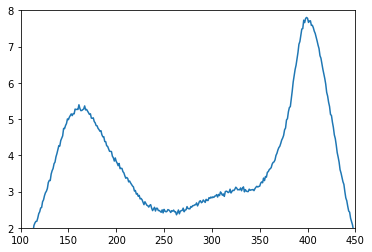

In [23]:
#Create arrays for full frequency scrunched pulse
x=profile['phase']
y=profile['intensity']

py.plot(x,y)
py.axis([100,450,2,8])

In [24]:
profile_peak1=160
profile_peak2=325
profile_peak3=400
plus_minus_range=75

## Gaussian Fitting - Broken Down for Each Frequency

From all the frequency profiles it takes only the one frequency band. 

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


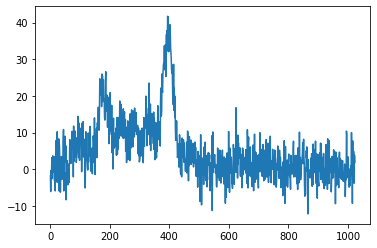

In [25]:
#Create arrays for full frequency scrunched pulse
ax=scrunched_pulse['phase']
ay=scrunched_pulse['intensity']
noise = sigmaClip(ay)
aerror = np.nanstd(noise[1])

#Find expected gaussian parameters based off frequency scrunched profile
expect=find_expected(ax,ay,aerror)

py.plot(ax,ay)

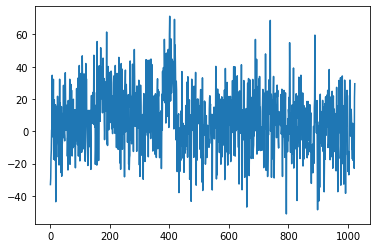

In [26]:
#Isolating a single frequency for a pulse
freqband = 9
f = single_pulse['frequency'] == freqband

x=single_pulse['phase'][f]
y=single_pulse['intensity'][f]
noise = sigmaClip(y)
error = np.nanstd(noise[1])
py.plot(x,y)

<ipython-input-27-f95635f180b4>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


pulse_sub(frequency=387.5, sub1=subpulse(phase=0, intensity=0), mid1=subpulse(phase=0, intensity=0), mid2=subpulse(phase=0, intensity=0), sub2=subpulse(phase=0, intensity=0), errors=[0, 0, 0, 0])


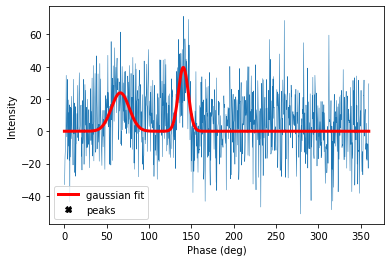

In [27]:
#Uses expected parameters and returns a fit for the frequency band
fit, params, sigma, cov, chir=fitting_gaussians(x,y,error, expect)
#If there is a fit, finds peaks where derivative is equal to zero
#Also classifys it as subpulse 1, 2, 3 or 4 depending on location
if fit!=[] and expect!=[]:
    pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500,error)
    plot_peaks(x,y, pulse_subp)
    print(pulse_subp)
elif fit==[]:
    print('No fit')
elif expect==[]:
    print('No expect')

# INDIVIDUAL PULSE

This section is mainly used for error checking the fit across frequency for an individual pulse.

## Gaussian Fitting 

The following is a looped version of the previous section to find the correct peaks for each frequency profile

In [28]:
fit_spulse = []
#Create arrays for full frequency scrunched pulse
ax=scrunched_pulse['phase']
ay=scrunched_pulse['intensity']
noise = sigmaClip(ay)
aerror = np.nanstd(noise[1])
#Find expected gaussian parameters based off frequency scrunched profile
expect=find_expected(ax,ay,aerror)

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


In [29]:
for i in range(no_freq_bands):
    #Creating arrays for pulse and finding frequency band noise
    freqband = i
    f = single_pulse['frequency'] == freqband
    x=single_pulse['phase'][f]
    y=single_pulse['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])
    
    #Try creating a gaussian fit, based on expected valyes from F scrunched profile
    if len(y)!=0:
        fit, params, sigma, cov, chir=fitting_gaussians(x,y,error,expect)
    #If a fit was created find peaks and separate into subpulse categories
    if len(y)!=0 and fit!=[] and expect!=[]:
        pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500, error) 
        fit_spulse.append(pulse_subp)

<ipython-input-29-9a0d957eb77b>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(y)!=0 and fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


## Change of Peak Position over Frequency

Used to visually show the movement of of each subpulse across frequency, this is looped later on for all pulses


In [30]:
#Create graphable arrays for subpulse 1
p1, f1, e1=graphing_spulse(fit_spulse,1)
#Graph points and removed outliers
if p1!=[]:
    py.errorbar(p1,f1, xerr=e1, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 1 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f1, p1, e1 = detect_outlier(f1, p1, e1,2)
    #Only include if there are 4 points or more, and range is less than 17
    if len(p1)>3 and (max(p1)-min(p1))<17:
        py.errorbar(p1,f1, xerr=e1, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p1,pl_c1=curve_fit(powerlaw,f1,p1, maxfev=100000, sigma=e1)
    pl_e1=np.sqrt(np.diag(pl_c1))
    powerlaw1 = powerlaw(f1, *pl_p1)

    py.plot(powerlaw1,f1, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p1,powerlaw1, e1)
    chre=ch/len(p1)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p1[0]:.3f} \u03BD^{pl_p1[1]:.3f}')
    print(f'The errors are {pl_e1[0]}, {pl_e1[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 1')

No power law for component 1


In [31]:
#Create graphable arrays for subpulse 2
p2, f2, e2=graphing_spulse(fit_spulse,2)
#Graph points and removed outliers
if p2!=[]:
    py.errorbar(p2,f2, xerr=e2, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 2 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f2, p2, e2 = detect_outlier(f2, p2, e2,1.5)
    #Only include if there are 4 points or more, and range is less than 10
    if len(p2)>3 and (max(p2)-min(p2))<10:
        py.errorbar(p2,f2, xerr=e2, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p2,pl_c2=curve_fit(powerlaw,f2,p2, maxfev=100000)
    pl_e2=np.sqrt(np.diag(pl_c2))
    powerlaw2 = powerlaw(f2, *pl_p2)

    py.plot(powerlaw2,f2, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p2,powerlaw2, e2)
    chre=ch/len(p2)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p2[0]:.3f} \u03BD^{pl_p2[1]:.3f}')
    print(f'The errors are {pl_e2[0]}, {pl_e2[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 2')

No power law for component 2


In [32]:
#Create graphable arrays for subpulse 3
p3, f3, e3=graphing_spulse(fit_spulse,3)
#Graph points and removed outliers
if p3!=[]:
    py.errorbar(p3,f3, xerr=e3, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 3 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f3, p3, e3 = detect_outlier(f3, p3, e3,1.5)
    #Only include if there are 4 points or more, and range is less than 10
    if len(p3)>3 and (max(p3)-min(p3))<10:
        py.errorbar(p3,f3, xerr=e3, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p3,pl_c3=curve_fit(powerlaw,f3,p3, maxfev=100000, sigma=e3)
    pl_e3=np.sqrt(np.diag(pl_c3))
    powerlaw3 = powerlaw(f3, *pl_p3)

    py.plot(powerlaw3,f3, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p3,powerlaw3, e3)
    chre=ch/len(p3)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p3[0]:.3f} \u03BD^{pl_p3[1]:.3f}')
    print(f'The errors are {pl_e3[0]}, {pl_e3[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 3')
    


No power law for component 3


The power law equation of fit for this pulse is: 	 Phase = 102.260 ν^0.052
The errors are 10.713859866482478, 0.01785295401437193
The chi squared reduced is -1.6921074626551764, and the chi squared is 1.5394626867241172



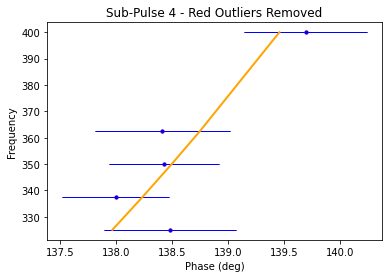

In [33]:
#Create graphable arrays for subpulse 4
p4, f4, e4=graphing_spulse(fit_spulse,4)
#Graph points and removed outliers
if p4!=[]:
    py.errorbar(p4,f4, xerr=e4, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 4 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f4, p4, e4 = detect_outlier(f4, p4, e4,2)
    #Only include if there are 4 points or more, and range is less than 5
    if len(p4)>3 and (max(p4)-min(p4))<5:
        py.errorbar(p4,f4, xerr=e4, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    expect=[100,0.1]
    pl_p4,pl_c4=curve_fit(powerlaw,f4,p4, expect, maxfev=100000, sigma=e4)
    pl_e4=np.sqrt(np.diag(pl_c4))
    powerlaw4 = powerlaw(f4, *pl_p4)

    py.plot(powerlaw4,f4, color='orange',lw=2,label='powerlaw')
    #py.axis((233,235,300,500))
        
    ch=chsq_err(p4,powerlaw4, e4)
    chre=ch/len(p4)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p4[0]:.3f} \u03BD^{pl_p4[1]:.3f}')
    print(f'The errors are {pl_e4[0]}, {pl_e4[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 4')
    
#py.axis([236,239,300,480])

In [34]:
def graph_subpulse_evo(fit_spulse,num,pulse):
    #Create graphable arrays for subpulse 4
    p, f, e=graphing_spulse(fit_spulse,num)
    #Graph points and removed outliers
    if p!=[]:
        spfig = py.figure(2)
        py.errorbar(p,f, xerr=e, fmt='.', color='red', lw=1, label='data')
        py.title(('Sub-Pulse '+ str(num) + ' - Red Outliers Removed'))
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        f, p, e = detect_outlier(f, p, e,2)
        #Only include if there are 4 points or more, and range is less than 5
        if len(p4)>3 and (max(p4)-min(p4))<5:
            py.errorbar(p,f, xerr=e, fmt='.', color='blue', lw=1, label='data')
    #Create a powerlaw fit and graph
    try:
        expect=[100,0.1]
        pl_p,pl_c=curve_fit(linear,f,p, expect, maxfev=100000, sigma=e)
        pl_e=np.sqrt(np.diag(pl_c))
        powerlaw = linear(f, *pl_p)

        py.plot(powerlaw,f, color='orange',lw=2,label='linear')
        py.savefig(('single_pulse_fig/'+str(pulse)+' - Subpulse - '+str(num)))
        py.clf(spfig)
    except:
        print(' ')

# ALL PULSES

In [36]:
"""
Manually removing fits which visually look inaccurate, too spread, or don't match the profile.
"""
def manual_removal(pulse_num, fits):
    if pulse_num==21 or pulse_num==62 or pulse_num==486 or pulse_num==554 or pulse_num==584 or pulse_num==694 or pulse_num==752 or pulse_num==1247:
        fits[0]=0
    if pulse_num==36 or pulse_num==175 or pulse_num==251:
        fits[1]=0
    if pulse_num==100 or pulse_num==133 or pulse_num==251 or pulse_num==287 or pulse_num==290 or pulse_num==291 or pulse_num==368 or pulse_num==513 or pulse_num==1116:
        fits[2]=0
    if pulse_num==31 or pulse_num==36 or pulse_num==263 or pulse_num==368 or pulse_num==479 or pulse_num==615 or pulse_num==635 or pulse_num==718 or pulse_num==832 or pulse_num==1128 or pulse_num==1256:
        fits[3]=0
    return fits

### Importing Files

In [35]:
#Import names of files into an array
#First file should lead to all single pulses which contain frequency information to be analysed
pulse_names = glob.glob("../new_archive/f256/pulse*.paz.f256.pdv")
#Second file should lead to all single pulses which are fully frequency scrunched
ave_names = glob.glob("../new_archive/F/pulse_*.paz.F.pdv")
#Sort the names in order
pulse_names=sorted(pulse_names)
ave_names=sorted(ave_names)

In [36]:
#linear([400.0, 362.5, 350.0, 337.5, 325.0],*[1.99548191e-02,1.31497793e+02])

1.99548191e-02*np.array([400.0, 362.5, 350.0, 337.5, 325.0])+1.31497793e+02

array([139.47972064, 138.73141492, 138.48197968, 138.23254445,
       137.98310921])

0 1503960511


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1 1503960512


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2 1503960513
3 1503960514
F scrunched pulse too noisey
4 1503960515
5 1503960516
6 1503960517
Plot 1
7 1503960518


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
8 1503960519


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9 1503960520
F scrunched pulse too noisey
10 1503960521
F scrunched pulse too noisey
11 1503960522
12 1503960523
Plot 4
13 1503960524


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
14 1503960525


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
15 1503960526


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


16 1503960527
Plot 4
17 1503960528


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


18 1503960529
F scrunched pulse too noisey
19 1503960530
20 1503960531


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
21 1503960532


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
22 1503960533


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
23 1503960534


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


24 1503960535


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
25 1503960536


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
26 1503960537
F scrunched pulse too noisey
27 1503960538


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


28 1503960539
29 1503960540


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


30 1503960541
Plot 4
31 1503960542


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


32 1503960543
Plot 4
33 1503960544


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


34 1503960545


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
35 1503960546


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
36 1503960547


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


37 1503960548
Plot 2
Plot 4
38 1503960549


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


39 1503960550
Plot 3
40 1503960551


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
41 1503960552


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
42 1503960553


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


43 1503960554
F scrunched pulse too noisey
44 1503960555
F scrunched pulse too noisey
45 1503960556


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
46 1503960557


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
47 1503960558
F scrunched pulse too noisey
48 1503960559


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
49 1503960560


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


50 1503960561
Plot 4
51 1503960562


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
52 1503960563


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
53 1503960564


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
54 1503960565


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


55 1503960566
56 1503960567


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


57 1503960568
58 1503960569
59 1503960570
60 1503960571


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
61 1503960572


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


62 1503960573
Plot 1
63 1503960574


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
64 1503960575
F scrunched pulse too noisey
65 1503960576
F scrunched pulse too noisey
66 1503960577
F scrunched pulse too noisey
67 1503960578
F scrunched pulse too noisey
68 1503960579
F scrunched pulse too noisey
69 1503960580


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
70 1503960581


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 3
71 1503960582


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
72 1503960583


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
73 1503960584


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
Plot 4
74 1503960585


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
75 1503960586


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
76 1503960587


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 3
77 1503960588


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
78 1503960589


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
79 1503960590


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


80 1503960591


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


81 1503960592
82 1503960593
83 1503960594
Plot 1
84 1503960595


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
85 1503960596


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
86 1503960597


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
87 1503960598


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


88 1503960599


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
89 1503960600


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


90 1503960601
F scrunched pulse too noisey
91 1503960602
92 1503960603
93 1503960604
94 1503960605
F scrunched pulse too noisey
95 1503960606
96 1503960607
Plot 4
97 1503960608


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
98 1503960609


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


99 1503960610


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
100 1503960611


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
Plot 4
101 1503960612


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
102 1503960613


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 2
103 1503960614


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


104 1503960615


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
105 1503960616


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
106 1503960617


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
107 1503960618


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
108 1503960619


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 3
109 1503960620


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
110 1503960621


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
111 1503960622


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
112 1503960623


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


113 1503960624


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
114 1503960625


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


115 1503960626
Plot 4
116 1503960627


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
117 1503960628


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


118 1503960629


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


119 1503960630
120 1503960631
Plot 4
121 1503960632


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 2
122 1503960633


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
123 1503960634


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


124 1503960635
F scrunched pulse too noisey
125 1503960636
126 1503960637


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
127 1503960638


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
128 1503960639


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
129 1503960640


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


130 1503960641


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
131 1503960642


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
132 1503960643


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
133 1503960644


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
134 1503960645


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


135 1503960646


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
Plot 4
136 1503960647


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
137 1503960648


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


138 1503960649


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
139 1503960650


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
140 1503960651


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
141 1503960652


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
142 1503960653


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
143 1503960654


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


144 1503960655
145 1503960656
146 1503960657


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 3
147 1503960658


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-14-efc19d7825da>:2: RuntimeWarning: overflow encountered in power
  return (A * (x**(alpha)) + smin)
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 3
148 1503960659


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
149 1503960660


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


150 1503960661
151 1503960662
152 1503960663
Plot 1
153 1503960664


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
154 1503960665


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
155 1503960666


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
156 1503960667


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


157 1503960668


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


158 1503960669
F scrunched pulse too noisey
159 1503960670
F scrunched pulse too noisey
160 1503960671
161 1503960672
F scrunched pulse too noisey
162 1503960673
F scrunched pulse too noisey
163 1503960674
F scrunched pulse too noisey
164 1503960675
F scrunched pulse too noisey
165 1503960676
Plot 1
166 1503960677


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
167 1503960678
F scrunched pulse too noisey
168 1503960679


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
169 1503960680


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
170 1503960681


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
171 1503960682


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
172 1503960683


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


173 1503960684
Plot 4
174 1503960685


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
175 1503960686
F scrunched pulse too noisey
176 1503960687
F scrunched pulse too noisey
177 1503960688


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
178 1503960689


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
179 1503960690
F scrunched pulse too noisey
180 1503960691


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


181 1503960692
Plot 1
182 1503960693


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
183 1503960694


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


184 1503960695
Plot 1
Plot 2
185 1503960696


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


186 1503960697
F scrunched pulse too noisey
187 1503960698
F scrunched pulse too noisey
188 1503960699
F scrunched pulse too noisey
189 1503960700
F scrunched pulse too noisey
190 1503960701
F scrunched pulse too noisey
191 1503960702
F scrunched pulse too noisey
192 1503960703
F scrunched pulse too noisey
193 1503960704
F scrunched pulse too noisey
194 1503960705
F scrunched pulse too noisey
195 1503960706
F scrunched pulse too noisey
196 1503960707
F scrunched pulse too noisey
197 1503960708
F scrunched pulse too noisey
198 1503960709
F scrunched pulse too noisey
199 1503960710
F scrunched pulse too noisey
200 1503960711
F scrunched pulse too noisey
201 1503960712
F scrunched pulse too noisey
202 1503960713
F scrunched pulse too noisey
203 1503960714
Fit = 0 - No fit created
F scrunched pulse too noisey
204 1503960715
Fit = 0 - No fit created
F scrunched pulse too noisey
205 1503960716
F scrunched pulse too noisey
206 1503960717
F scrunched pulse too noisey
207 1503960718
208 1503960

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


224 1503960735
F scrunched pulse too noisey
225 1503960736
F scrunched pulse too noisey
226 1503960737
F scrunched pulse too noisey
227 1503960738
F scrunched pulse too noisey
228 1503960739
F scrunched pulse too noisey
229 1503960740
Plot 4
230 1503960741


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
231 1503960742


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
232 1503960743


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
233 1503960744


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
234 1503960745


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
235 1503960746


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


236 1503960747
237 1503960748
F scrunched pulse too noisey
238 1503960749
F scrunched pulse too noisey
239 1503960750
F scrunched pulse too noisey
240 1503960751
F scrunched pulse too noisey
241 1503960752
F scrunched pulse too noisey
242 1503960753
F scrunched pulse too noisey
243 1503960754
F scrunched pulse too noisey
244 1503960755
F scrunched pulse too noisey
245 1503960756
Plot 4
246 1503960757


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
247 1503960758
F scrunched pulse too noisey
248 1503960759
F scrunched pulse too noisey
249 1503960760
F scrunched pulse too noisey
250 1503960761


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


251 1503960762
Plot 1
Plot 2
252 1503960763


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
253 1503960764


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
254 1503960765


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


255 1503960766
F scrunched pulse too noisey
256 1503960767
F scrunched pulse too noisey
257 1503960768
Plot 3
258 1503960769


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
259 1503960770


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
260 1503960771


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 3
261 1503960772


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
262 1503960773


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
263 1503960774


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
264 1503960775


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 4
265 1503960776


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
266 1503960777


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


267 1503960778
F scrunched pulse too noisey
268 1503960779
F scrunched pulse too noisey
269 1503960780


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
270 1503960781
Plot 3
271 1503960782


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
272 1503960783


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
273 1503960784


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
274 1503960785


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


275 1503960786
F scrunched pulse too noisey
276 1503960787
F scrunched pulse too noisey
277 1503960788
F scrunched pulse too noisey
278 1503960789
F scrunched pulse too noisey
279 1503960790
F scrunched pulse too noisey
280 1503960791
F scrunched pulse too noisey
281 1503960792
F scrunched pulse too noisey
282 1503960793
F scrunched pulse too noisey
283 1503960794
F scrunched pulse too noisey
284 1503960795
Fit = 0 - No fit created
F scrunched pulse too noisey
285 1503960796


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 2
Plot 3
286 1503960797


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
287 1503960798


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 3
288 1503960799


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
289 1503960800


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
290 1503960801


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 3
291 1503960802


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
292 1503960803


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


293 1503960804
F scrunched pulse too noisey
294 1503960805
F scrunched pulse too noisey
295 1503960806
F scrunched pulse too noisey
296 1503960807
F scrunched pulse too noisey
297 1503960808
F scrunched pulse too noisey
298 1503960809
Fit = 0 - No fit created
F scrunched pulse too noisey
299 1503960810
F scrunched pulse too noisey
300 1503960811
Fit = 0 - No fit created
F scrunched pulse too noisey
301 1503960812
F scrunched pulse too noisey
302 1503960813
F scrunched pulse too noisey
303 1503960814
F scrunched pulse too noisey
304 1503960815
F scrunched pulse too noisey
305 1503960816
F scrunched pulse too noisey
306 1503960817
F scrunched pulse too noisey
307 1503960818
Fit = 0 - No fit created
F scrunched pulse too noisey
308 1503960819
F scrunched pulse too noisey
309 1503960820
310 1503960821
F scrunched pulse too noisey
311 1503960822
Fit = 0 - No fit created
F scrunched pulse too noisey
312 1503960823
F scrunched pulse too noisey
313 1503960824
314 1503960825
F scrunched pulse t

/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 3
Plot 4
369 1503960880


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
370 1503960881


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
371 1503960882


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
372 1503960883


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 4
373 1503960884


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 3
Plot 4
374 1503960885


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
375 1503960886


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
376 1503960887


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
377 1503960888


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
378 1503960889


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
379 1503960890


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


380 1503960891
381 1503960892


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
382 1503960893


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
383 1503960894


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
384 1503960895


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
385 1503960896


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
386 1503960897


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


387 1503960898
Plot 4
388 1503960899


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
389 1503960900
F scrunched pulse too noisey
390 1503960901
F scrunched pulse too noisey
391 1503960902


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
392 1503960903
Fit = 0 - No fit created
F scrunched pulse too noisey
393 1503960904
F scrunched pulse too noisey
394 1503960905
F scrunched pulse too noisey
395 1503960906


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


396 1503960907
F scrunched pulse too noisey
397 1503960908
Fit = 0 - No fit created
F scrunched pulse too noisey
398 1503960909
F scrunched pulse too noisey
399 1503960910
Fit = 0 - No fit created
F scrunched pulse too noisey
400 1503960911
401 1503960912
F scrunched pulse too noisey
402 1503960913
F scrunched pulse too noisey
403 1503960914


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


404 1503960915


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
405 1503960916


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
406 1503960917


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
407 1503960918


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


408 1503960919
409 1503960920


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
410 1503960921


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
411 1503960922


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
412 1503960923


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
413 1503960924


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
414 1503960925


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
415 1503960926
F scrunched pulse too noisey
416 1503960927
F scrunched pulse too noisey
417 1503960928
F scrunched pulse too noisey
418 1503960929


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
419 1503960930
Fit = 0 - No fit created
F scrunched pulse too noisey
420 1503960931
F scrunched pulse too noisey
421 1503960932
F scrunched pulse too noisey
422 1503960933
F scrunched pulse too noisey
423 1503960934
F scrunched pulse too noisey
424 1503960935
F scrunched pulse too noisey
425 1503960936
F scrunched pulse too noisey
426 1503960937
F scrunched pulse too noisey
427 1503960938
F scrunched pulse too noisey
428 1503960939
F scrunched pulse too noisey
429 1503960940
F scrunched pulse too noisey
430 1503960941
F scrunched pulse too noisey
431 1503960942
F scrunched pulse too noisey
432 1503960943
F scrunched pulse too noisey
433 1503960944
F scrunched pulse too noisey
434 1503960945
F scrunched pulse too noisey
435 1503960946
F scrunched pulse too noisey
436 1503960947
F scrunched pulse too noisey
437 1503960948
F scrunched pulse too noisey
438 1503960949
Fit = 0 - No fit created
F scrunched pulse too noisey
439 1503960950
F scrunched pulse too nois

<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


441 1503960952
Fit = 0 - No fit created
F scrunched pulse too noisey
442 1503960953
F scrunched pulse too noisey
443 1503960954
F scrunched pulse too noisey
444 1503960955


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


445 1503960956
F scrunched pulse too noisey
446 1503960957
F scrunched pulse too noisey
447 1503960958
F scrunched pulse too noisey
448 1503960959
F scrunched pulse too noisey
449 1503960960
F scrunched pulse too noisey
450 1503960961
451 1503960962
F scrunched pulse too noisey
452 1503960963
F scrunched pulse too noisey
453 1503960964
F scrunched pulse too noisey
454 1503960965
F scrunched pulse too noisey
455 1503960966
F scrunched pulse too noisey
456 1503960967
F scrunched pulse too noisey
457 1503960968
F scrunched pulse too noisey
458 1503960969
F scrunched pulse too noisey
459 1503960970
F scrunched pulse too noisey
460 1503960971
F scrunched pulse too noisey
461 1503960972
F scrunched pulse too noisey
462 1503960973
F scrunched pulse too noisey
463 1503960974
F scrunched pulse too noisey
464 1503960975
Fit = 0 - No fit created
F scrunched pulse too noisey
465 1503960976
F scrunched pulse too noisey
466 1503960977
F scrunched pulse too noisey
467 1503960978


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
468 1503960979


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


469 1503960980
F scrunched pulse too noisey
470 1503960981
471 1503960982
F scrunched pulse too noisey
472 1503960983
473 1503960984
F scrunched pulse too noisey
474 1503960985
F scrunched pulse too noisey
475 1503960986
F scrunched pulse too noisey
476 1503960987
477 1503960988


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
478 1503960989


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


479 1503960990
Plot 4
480 1503960991


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


481 1503960992


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
482 1503960993


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
483 1503960994


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
484 1503960995


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


485 1503960996


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
Plot 4
486 1503960997


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
487 1503960998


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
488 1503960999


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


489 1503961000
490 1503961001


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 4
491 1503961002


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


492 1503961003


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 4
493 1503961004


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
494 1503961005


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


495 1503961006
F scrunched pulse too noisey
496 1503961007
F scrunched pulse too noisey
497 1503961008
F scrunched pulse too noisey
498 1503961009
F scrunched pulse too noisey
499 1503961010
F scrunched pulse too noisey
500 1503961011
F scrunched pulse too noisey
501 1503961012
502 1503961013
F scrunched pulse too noisey
503 1503961014
F scrunched pulse too noisey
504 1503961015
F scrunched pulse too noisey
505 1503961016
F scrunched pulse too noisey
506 1503961017
F scrunched pulse too noisey
507 1503961018
F scrunched pulse too noisey
508 1503961019
F scrunched pulse too noisey
509 1503961020
F scrunched pulse too noisey
510 1503961021
F scrunched pulse too noisey
511 1503961022
F scrunched pulse too noisey
512 1503961023
Plot 2
513 1503961024


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 3
Plot 4
514 1503961025


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
515 1503961026


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
516 1503961027


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


517 1503961028
F scrunched pulse too noisey
518 1503961029
519 1503961030
F scrunched pulse too noisey
520 1503961031
F scrunched pulse too noisey
521 1503961032
F scrunched pulse too noisey
522 1503961033
F scrunched pulse too noisey
523 1503961034
F scrunched pulse too noisey
524 1503961035
F scrunched pulse too noisey
525 1503961036
F scrunched pulse too noisey
526 1503961037
F scrunched pulse too noisey
527 1503961038
F scrunched pulse too noisey
528 1503961039
F scrunched pulse too noisey
529 1503961040
F scrunched pulse too noisey
530 1503961041
531 1503961042
532 1503961043
533 1503961044
534 1503961045
535 1503961046
536 1503961047
537 1503961048
538 1503961049


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
539 1503961050


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
540 1503961051


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
541 1503961052


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
542 1503961053


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
543 1503961054


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
544 1503961055
F scrunched pulse too noisey
545 1503961056
F scrunched pulse too noisey
546 1503961057
F scrunched pulse too noisey
547 1503961058


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
548 1503961059


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
549 1503961060


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
550 1503961061


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
551 1503961062


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
552 1503961063


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
553 1503961064


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
554 1503961065


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
555 1503961066


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


556 1503961067
F scrunched pulse too noisey
557 1503961068
F scrunched pulse too noisey
558 1503961069
F scrunched pulse too noisey
559 1503961070
Plot 1
560 1503961071


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
561 1503961072


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
562 1503961073
Fit = 0 - No fit created
F scrunched pulse too noisey
563 1503961074


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
564 1503961075


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


565 1503961076
F scrunched pulse too noisey
566 1503961077
F scrunched pulse too noisey
567 1503961078
F scrunched pulse too noisey
568 1503961079
F scrunched pulse too noisey
569 1503961080
F scrunched pulse too noisey
570 1503961081
F scrunched pulse too noisey
571 1503961082
F scrunched pulse too noisey
572 1503961083
F scrunched pulse too noisey
573 1503961084
F scrunched pulse too noisey
574 1503961085
F scrunched pulse too noisey
575 1503961086
F scrunched pulse too noisey
576 1503961087
F scrunched pulse too noisey
577 1503961088


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
578 1503961089


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
579 1503961090


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
580 1503961091


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
581 1503961092


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


582 1503961093
583 1503961094
Plot 1
584 1503961095


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
585 1503961096


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
586 1503961097


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


587 1503961098
588 1503961099


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
589 1503961100


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
590 1503961101


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
591 1503961102


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
592 1503961103


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
593 1503961104


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


594 1503961105
595 1503961106
596 1503961107
Plot 4
597 1503961108


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


598 1503961109


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
Plot 4
599 1503961110


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


600 1503961111
601 1503961112
Plot 4
602 1503961113


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
603 1503961114


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


604 1503961115
F scrunched pulse too noisey
605 1503961116
F scrunched pulse too noisey
606 1503961117
F scrunched pulse too noisey
607 1503961118
608 1503961119
609 1503961120


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
610 1503961121


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
611 1503961122


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
612 1503961123


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
613 1503961124


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
614 1503961125


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


615 1503961126


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
616 1503961127


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
617 1503961128


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
618 1503961129


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


619 1503961130
620 1503961131
621 1503961132
622 1503961133
F scrunched pulse too noisey
623 1503961134
F scrunched pulse too noisey
624 1503961135
625 1503961136
626 1503961137


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
627 1503961138


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
628 1503961139


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
629 1503961140


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
630 1503961141


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


631 1503961142
632 1503961143
633 1503961144
634 1503961145
635 1503961146
Plot 4
636 1503961147


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


637 1503961148
Plot 4
638 1503961149


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
639 1503961150


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
640 1503961151


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


641 1503961152
F scrunched pulse too noisey
642 1503961153
643 1503961154
644 1503961155
F scrunched pulse too noisey
645 1503961156
Plot 1
646 1503961157


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
647 1503961158


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
648 1503961159


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


649 1503961160


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


650 1503961161
651 1503961162
652 1503961163
Plot 4
653 1503961164


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


654 1503961165
Plot 4
655 1503961166


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


656 1503961167
657 1503961168
F scrunched pulse too noisey
658 1503961169
659 1503961170
F scrunched pulse too noisey
660 1503961171
F scrunched pulse too noisey
661 1503961172
F scrunched pulse too noisey
662 1503961173
663 1503961174
Fit = 0 - No fit created
F scrunched pulse too noisey
664 1503961175
F scrunched pulse too noisey
665 1503961176
F scrunched pulse too noisey
666 1503961177
Plot 4
667 1503961178


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
668 1503961179


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


669 1503961180
670 1503961181
671 1503961182
672 1503961183
F scrunched pulse too noisey
673 1503961184
F scrunched pulse too noisey
674 1503961185
F scrunched pulse too noisey
675 1503961186
F scrunched pulse too noisey
676 1503961187
F scrunched pulse too noisey
677 1503961188
F scrunched pulse too noisey
678 1503961189


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


679 1503961190
F scrunched pulse too noisey
680 1503961191
F scrunched pulse too noisey
681 1503961192
F scrunched pulse too noisey
682 1503961193
F scrunched pulse too noisey
683 1503961194
684 1503961195
685 1503961196
686 1503961197
687 1503961198
688 1503961199
689 1503961200
690 1503961201
F scrunched pulse too noisey
691 1503961202
Fit = 0 - No fit created
F scrunched pulse too noisey
692 1503961203
693 1503961204
694 1503961205
695 1503961206
F scrunched pulse too noisey
696 1503961207
697 1503961208
F scrunched pulse too noisey
698 1503961209
699 1503961210
700 1503961211


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
701 1503961212


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


702 1503961213


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
703 1503961214


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


704 1503961215
Plot 4
705 1503961216


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
706 1503961217
F scrunched pulse too noisey
707 1503961218
F scrunched pulse too noisey
708 1503961219


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


709 1503961220
F scrunched pulse too noisey
710 1503961221
F scrunched pulse too noisey
711 1503961222
712 1503961223
Plot 1
713 1503961224


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
714 1503961225


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


715 1503961226


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


716 1503961227
717 1503961228
718 1503961229
719 1503961230
Plot 4
720 1503961231


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


721 1503961232


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


722 1503961233
F scrunched pulse too noisey
723 1503961234
724 1503961235
F scrunched pulse too noisey
725 1503961236
F scrunched pulse too noisey
726 1503961237
F scrunched pulse too noisey
727 1503961238
F scrunched pulse too noisey
728 1503961239
729 1503961240
F scrunched pulse too noisey
730 1503961241
731 1503961242
F scrunched pulse too noisey
732 1503961243
F scrunched pulse too noisey
733 1503961244
F scrunched pulse too noisey
734 1503961245
F scrunched pulse too noisey
735 1503961246
F scrunched pulse too noisey
736 1503961247
F scrunched pulse too noisey
737 1503961248
F scrunched pulse too noisey
738 1503961249
739 1503961250
740 1503961251
741 1503961252


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
742 1503961253


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


743 1503961254


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


744 1503961255
745 1503961256
746 1503961257
F scrunched pulse too noisey
747 1503961258
Fit = 0 - No fit created
F scrunched pulse too noisey
748 1503961259
F scrunched pulse too noisey
749 1503961260
F scrunched pulse too noisey
750 1503961261
F scrunched pulse too noisey
751 1503961262
F scrunched pulse too noisey
752 1503961263


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 1
753 1503961264


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
754 1503961265
F scrunched pulse too noisey
755 1503961266
F scrunched pulse too noisey
756 1503961267
F scrunched pulse too noisey
757 1503961268
F scrunched pulse too noisey
758 1503961269
F scrunched pulse too noisey
759 1503961270
F scrunched pulse too noisey
760 1503961271
F scrunched pulse too noisey
761 1503961272
F scrunched pulse too noisey
762 1503961273


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


763 1503961274
F scrunched pulse too noisey
764 1503961275
F scrunched pulse too noisey
765 1503961276
F scrunched pulse too noisey
766 1503961277
F scrunched pulse too noisey
767 1503961278
F scrunched pulse too noisey
768 1503961279
F scrunched pulse too noisey
769 1503961280
F scrunched pulse too noisey
770 1503961281
F scrunched pulse too noisey
771 1503961282
F scrunched pulse too noisey
772 1503961283
F scrunched pulse too noisey
773 1503961284
F scrunched pulse too noisey
774 1503961285
F scrunched pulse too noisey
775 1503961286
F scrunched pulse too noisey
776 1503961287
F scrunched pulse too noisey
777 1503961288
F scrunched pulse too noisey
778 1503961289
F scrunched pulse too noisey
779 1503961290
F scrunched pulse too noisey
780 1503961291
F scrunched pulse too noisey
781 1503961292
F scrunched pulse too noisey
782 1503961293
F scrunched pulse too noisey
783 1503961294
F scrunched pulse too noisey
784 1503961295
F scrunched pulse too noisey
785 1503961296
F scrunched pulse

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
833 1503961344


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
834 1503961345


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
835 1503961346
F scrunched pulse too noisey
836 1503961347
F scrunched pulse too noisey
837 1503961348


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


838 1503961349
F scrunched pulse too noisey
839 1503961350
F scrunched pulse too noisey
840 1503961351
Plot 1
841 1503961352


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
842 1503961353


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


843 1503961354
844 1503961355
F scrunched pulse too noisey
845 1503961356
846 1503961357
847 1503961358
848 1503961359
F scrunched pulse too noisey
849 1503961360
F scrunched pulse too noisey
850 1503961361
F scrunched pulse too noisey
851 1503961362
F scrunched pulse too noisey
852 1503961363
F scrunched pulse too noisey
853 1503961364
F scrunched pulse too noisey
854 1503961365
F scrunched pulse too noisey
855 1503961366
F scrunched pulse too noisey
856 1503961367
F scrunched pulse too noisey
857 1503961368
F scrunched pulse too noisey
858 1503961369
859 1503961370
F scrunched pulse too noisey
860 1503961371
F scrunched pulse too noisey
861 1503961372
F scrunched pulse too noisey
862 1503961373
863 1503961374
F scrunched pulse too noisey
864 1503961375
Fit = 0 - No fit created
F scrunched pulse too noisey
865 1503961376
F scrunched pulse too noisey
866 1503961377
F scrunched pulse too noisey
867 1503961378
F scrunched pulse too noisey
868 1503961379
F scrunched pulse too noisey
869 1

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


984 1503961495


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
985 1503961496


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


986 1503961497


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


987 1503961498
F scrunched pulse too noisey
988 1503961499
Plot 1
989 1503961500


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
990 1503961501


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
991 1503961502


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


992 1503961503


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


993 1503961504
F scrunched pulse too noisey
994 1503961505
995 1503961506
996 1503961507


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
997 1503961508


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


998 1503961509
999 1503961510
F scrunched pulse too noisey
1000 1503961511
F scrunched pulse too noisey
1001 1503961512
F scrunched pulse too noisey
1002 1503961513
F scrunched pulse too noisey
1003 1503961514
F scrunched pulse too noisey
1004 1503961515
1005 1503961516
F scrunched pulse too noisey
1006 1503961517
F scrunched pulse too noisey
1007 1503961518
F scrunched pulse too noisey
1008 1503961519
F scrunched pulse too noisey
1009 1503961520
1010 1503961521
F scrunched pulse too noisey
1011 1503961522
F scrunched pulse too noisey
1012 1503961523
1013 1503961524
1014 1503961525
1015 1503961526
1016 1503961527
F scrunched pulse too noisey
1017 1503961528
F scrunched pulse too noisey
1018 1503961529
F scrunched pulse too noisey
1019 1503961530
F scrunched pulse too noisey
1020 1503961531
F scrunched pulse too noisey
1021 1503961532
F scrunched pulse too noisey
1022 1503961533
F scrunched pulse too noisey
1023 1503961534
F scrunched pulse too noisey
1024 1503961535
F scrunched pulse t

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1030 1503961541


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1031 1503961542
F scrunched pulse too noisey
1032 1503961543
Fit = 0 - No fit created
F scrunched pulse too noisey
1033 1503961544
F scrunched pulse too noisey
1034 1503961545
F scrunched pulse too noisey
1035 1503961546
F scrunched pulse too noisey
1036 1503961547


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
1037 1503961548


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1038 1503961549
1039 1503961550
1040 1503961551
F scrunched pulse too noisey
1041 1503961552
1042 1503961553
1043 1503961554
F scrunched pulse too noisey
1044 1503961555
F scrunched pulse too noisey
1045 1503961556
1046 1503961557
F scrunched pulse too noisey
1047 1503961558
F scrunched pulse too noisey
1048 1503961559
F scrunched pulse too noisey
1049 1503961560
F scrunched pulse too noisey
1050 1503961561
F scrunched pulse too noisey
1051 1503961562
F scrunched pulse too noisey
1052 1503961563
F scrunched pulse too noisey
1053 1503961564
1054 1503961565
F scrunched pulse too noisey
1055 1503961566
1056 1503961567
F scrunched pulse too noisey
1057 1503961568
F scrunched pulse too noisey
1058 1503961569
1059 1503961570
F scrunched pulse too noisey
1060 1503961571
1061 1503961572
1062 1503961573
F scrunched pulse too noisey
1063 1503961574
F scrunched pulse too noisey
1064 1503961575
F scrunched pulse too noisey
1065 1503961576
F scrunched pulse too noisey
1066 1503961577
F scrunched pu

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1127 1503961638
F scrunched pulse too noisey
1128 1503961639


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1129 1503961640
F scrunched pulse too noisey
1130 1503961641


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1131 1503961642
Plot 1
1132 1503961643


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1133 1503961644
1134 1503961645
1135 1503961646
1136 1503961647
1137 1503961648
F scrunched pulse too noisey
1138 1503961649
F scrunched pulse too noisey
1139 1503961650
F scrunched pulse too noisey
1140 1503961651
F scrunched pulse too noisey
1141 1503961652
1142 1503961653
F scrunched pulse too noisey
1143 1503961654
1144 1503961655
1145 1503961656
F scrunched pulse too noisey
1146 1503961657
F scrunched pulse too noisey
1147 1503961658
1148 1503961659
F scrunched pulse too noisey
1149 1503961660
1150 1503961661
F scrunched pulse too noisey
1151 1503961662
F scrunched pulse too noisey
1152 1503961663
F scrunched pulse too noisey
1153 1503961664
F scrunched pulse too noisey
1154 1503961665
1155 1503961666
Plot 4
1156 1503961667


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1157 1503961668
F scrunched pulse too noisey
1158 1503961669
F scrunched pulse too noisey
1159 1503961670
F scrunched pulse too noisey
1160 1503961671
F scrunched pulse too noisey
1161 1503961672
F scrunched pulse too noisey
1162 1503961673


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1163 1503961674
F scrunched pulse too noisey
1164 1503961675
F scrunched pulse too noisey
1165 1503961676
F scrunched pulse too noisey
1166 1503961677
F scrunched pulse too noisey
1167 1503961678
F scrunched pulse too noisey
1168 1503961679
F scrunched pulse too noisey
1169 1503961680
F scrunched pulse too noisey
1170 1503961681
F scrunched pulse too noisey
1171 1503961682
F scrunched pulse too noisey
1172 1503961683
F scrunched pulse too noisey
1173 1503961684
F scrunched pulse too noisey
1174 1503961685


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1175 1503961686
F scrunched pulse too noisey
1176 1503961687
F scrunched pulse too noisey
1177 1503961688
F scrunched pulse too noisey
1178 1503961689
F scrunched pulse too noisey
1179 1503961690
F scrunched pulse too noisey
1180 1503961691
F scrunched pulse too noisey
1181 1503961692
F scrunched pulse too noisey
1182 1503961693
Fit = 0 - No fit created
F scrunched pulse too noisey
1183 1503961694
F scrunched pulse too noisey
1184 1503961695
F scrunched pulse too noisey
1185 1503961696
F scrunched pulse too noisey
1186 1503961697
F scrunched pulse too noisey
1187 1503961698
F scrunched pulse too noisey
1188 1503961699
F scrunched pulse too noisey
1189 1503961700
F scrunched pulse too noisey
1190 1503961701
F scrunched pulse too noisey
1191 1503961702
F scrunched pulse too noisey
1192 1503961703
F scrunched pulse too noisey
1193 1503961704
F scrunched pulse too noisey
1194 1503961705
F scrunched pulse too noisey
1195 1503961706
F scrunched pulse too noisey
1196 1503961707
F scrunched pu

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
1210 1503961721


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1211 1503961722
F scrunched pulse too noisey
1212 1503961723
F scrunched pulse too noisey
1213 1503961724


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1214 1503961725
F scrunched pulse too noisey
1215 1503961726
Plot 4
1216 1503961727


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1217 1503961728
F scrunched pulse too noisey
1218 1503961729
F scrunched pulse too noisey
1219 1503961730


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1220 1503961731


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1221 1503961732
1222 1503961733
F scrunched pulse too noisey
1223 1503961734
F scrunched pulse too noisey
1224 1503961735
1225 1503961736
F scrunched pulse too noisey
1226 1503961737
F scrunched pulse too noisey
1227 1503961738
F scrunched pulse too noisey
1228 1503961739
F scrunched pulse too noisey
1229 1503961740
F scrunched pulse too noisey
1230 1503961741
F scrunched pulse too noisey
1231 1503961742
1232 1503961743
1233 1503961744
1234 1503961745
F scrunched pulse too noisey
1235 1503961746
F scrunched pulse too noisey
1236 1503961747
F scrunched pulse too noisey
1237 1503961748
F scrunched pulse too noisey
1238 1503961749
1239 1503961750
F scrunched pulse too noisey
1240 1503961751
F scrunched pulse too noisey
1241 1503961752
F scrunched pulse too noisey
1242 1503961753
F scrunched pulse too noisey
1243 1503961754
Fit = 0 - No fit created
F scrunched pulse too noisey
1244 1503961755
Fit = 0 - No fit created
F scrunched pulse too noisey
1245 1503961756
F scrunched pulse too noisey

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1248 1503961759


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1249 1503961760
F scrunched pulse too noisey
1250 1503961761
F scrunched pulse too noisey
1251 1503961762
1252 1503961763
1253 1503961764
Plot 4
1254 1503961765


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1255 1503961766


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1256 1503961767


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
1257 1503961768


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1258 1503961769


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1259 1503961770
F scrunched pulse too noisey
1260 1503961771
F scrunched pulse too noisey
1261 1503961772
F scrunched pulse too noisey
1262 1503961773
F scrunched pulse too noisey
1263 1503961774
1264 1503961775
1265 1503961776
F scrunched pulse too noisey
1266 1503961777
F scrunched pulse too noisey
1267 1503961778
1268 1503961779
1269 1503961780
1270 1503961781
1271 1503961782
1272 1503961783
1273 1503961784
1274 1503961785
1275 1503961786
1276 1503961787
F scrunched pulse too noisey
1277 1503961788
1278 1503961789
1279 1503961790
1280 1503961791
1281 1503961792
1282 1503961793
F scrunched pulse too noisey
1283 1503961794
F scrunched pulse too noisey
1284 1503961795
1285 1503961796
F scrunched pulse too noisey
1286 1503961797
F scrunched pulse too noisey
1287 1503961798
F scrunched pulse too noisey
1288 1503961799
1289 1503961800
F scrunched pulse too noisey
1290 1503961801
Plot 1
1291 1503961802


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1292 1503961803
F scrunched pulse too noisey
1293 1503961804
F scrunched pulse too noisey
1294 1503961805


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1295 1503961806
F scrunched pulse too noisey
1296 1503961807
1297 1503961808
Plot 4
1298 1503961809


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1299 1503961810


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1300 1503961811


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1301 1503961812
Fit = 0 - No fit created
F scrunched pulse too noisey
1302 1503961813


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1303 1503961814
Fit = 0 - No fit created
F scrunched pulse too noisey
1304 1503961815
F scrunched pulse too noisey
1305 1503961816
F scrunched pulse too noisey
1306 1503961817
F scrunched pulse too noisey
1307 1503961818
F scrunched pulse too noisey
1308 1503961819
F scrunched pulse too noisey
1309 1503961820
Fit = 0 - No fit created
F scrunched pulse too noisey
1310 1503961821
F scrunched pulse too noisey
1311 1503961822
F scrunched pulse too noisey
1312 1503961823


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1313 1503961824
F scrunched pulse too noisey
1314 1503961825
F scrunched pulse too noisey
1315 1503961826


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1316 1503961827
F scrunched pulse too noisey
1317 1503961828
F scrunched pulse too noisey
1318 1503961829
F scrunched pulse too noisey
1319 1503961830
F scrunched pulse too noisey
1320 1503961831
F scrunched pulse too noisey
1321 1503961832
F scrunched pulse too noisey
1322 1503961833
F scrunched pulse too noisey
1323 1503961834
F scrunched pulse too noisey
1324 1503961835
F scrunched pulse too noisey
1325 1503961836
F scrunched pulse too noisey
1326 1503961837
F scrunched pulse too noisey
1327 1503961838
F scrunched pulse too noisey
1328 1503961839
F scrunched pulse too noisey
1329 1503961840
Fit = 0 - No fit created
F scrunched pulse too noisey
1330 1503961841
F scrunched pulse too noisey
1331 1503961842
F scrunched pulse too noisey
1332 1503961843
F scrunched pulse too noisey
1333 1503961844
F scrunched pulse too noisey
1334 1503961845
F scrunched pulse too noisey
1335 1503961846
F scrunched pulse too noisey
1336 1503961847
1337 1503961848
F scrunched pulse too noisey
1338 150396184

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
1344 1503961855


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1345 1503961856
F scrunched pulse too noisey
1346 1503961857


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1347 1503961858
F scrunched pulse too noisey
1348 1503961859
1349 1503961860
F scrunched pulse too noisey
1350 1503961861
F scrunched pulse too noisey
1351 1503961862
F scrunched pulse too noisey
1352 1503961863
1353 1503961864


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
1354 1503961865


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1355 1503961866
F scrunched pulse too noisey
1356 1503961867


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1357 1503961868


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1358 1503961869
F scrunched pulse too noisey
1359 1503961870
F scrunched pulse too noisey
1360 1503961871


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1361 1503961872
1362 1503961873
F scrunched pulse too noisey
1363 1503961874


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1364 1503961875


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1365 1503961876
1366 1503961877


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1367 1503961878


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1368 1503961879


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1369 1503961880


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1370 1503961881


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1371 1503961882


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1372 1503961883
F scrunched pulse too noisey
1373 1503961884
1374 1503961885
F scrunched pulse too noisey
1375 1503961886
1376 1503961887


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1377 1503961888
1378 1503961889
1379 1503961890
F scrunched pulse too noisey
1380 1503961891
F scrunched pulse too noisey
1381 1503961892
F scrunched pulse too noisey
1382 1503961893
1383 1503961894
Plot 1
1384 1503961895


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
1385 1503961896


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1386 1503961897


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1387 1503961898


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1388 1503961899
F scrunched pulse too noisey
1389 1503961900
F scrunched pulse too noisey
1390 1503961901
F scrunched pulse too noisey
1391 1503961902
F scrunched pulse too noisey
1392 1503961903
F scrunched pulse too noisey
1393 1503961904
F scrunched pulse too noisey
1394 1503961905
F scrunched pulse too noisey
1395 1503961906
1396 1503961907
F scrunched pulse too noisey
1397 1503961908
1398 1503961909
1399 1503961910
1400 1503961911
1401 1503961912
1402 1503961913
1403 1503961914
Plot 4
1404 1503961915


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1405 1503961916


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1406 1503961917
1407 1503961918
F scrunched pulse too noisey
1408 1503961919
F scrunched pulse too noisey
1409 1503961920
1410 1503961921
Plot 1
1411 1503961922


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1412 1503961923


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1413 1503961924


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1414 1503961925
F scrunched pulse too noisey
1415 1503961926
1416 1503961927
1417 1503961928
1418 1503961929
1419 1503961930
1420 1503961931
F scrunched pulse too noisey
1421 1503961932
F scrunched pulse too noisey
1422 1503961933
Plot 4
1423 1503961934


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1424 1503961935
F scrunched pulse too noisey
1425 1503961936
F scrunched pulse too noisey
1426 1503961937
F scrunched pulse too noisey
1427 1503961938
F scrunched pulse too noisey
1428 1503961939
F scrunched pulse too noisey
1429 1503961940
F scrunched pulse too noisey
1430 1503961941


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1431 1503961942
F scrunched pulse too noisey
1432 1503961943
F scrunched pulse too noisey
1433 1503961944
F scrunched pulse too noisey
1434 1503961945
F scrunched pulse too noisey
1435 1503961946
F scrunched pulse too noisey
1436 1503961947
F scrunched pulse too noisey
1437 1503961948
F scrunched pulse too noisey
1438 1503961949
F scrunched pulse too noisey
1439 1503961950


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1440 1503961951
F scrunched pulse too noisey
1441 1503961952
1442 1503961953
F scrunched pulse too noisey
1443 1503961954
F scrunched pulse too noisey
1444 1503961955
1445 1503961956
F scrunched pulse too noisey
1446 1503961957
F scrunched pulse too noisey
1447 1503961958
F scrunched pulse too noisey
1448 1503961959
F scrunched pulse too noisey
1449 1503961960
F scrunched pulse too noisey
1450 1503961961
F scrunched pulse too noisey
1451 1503961962
F scrunched pulse too noisey
1452 1503961963
F scrunched pulse too noisey
1453 1503961964
F scrunched pulse too noisey
1454 1503961965
F scrunched pulse too noisey
1455 1503961966
F scrunched pulse too noisey
1456 1503961967
F scrunched pulse too noisey
1457 1503961968
F scrunched pulse too noisey
1458 1503961969
F scrunched pulse too noisey
1459 1503961970
1460 1503961971


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1461 1503961972


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1462 1503961973
F scrunched pulse too noisey
1463 1503961974
F scrunched pulse too noisey
1464 1503961975
1465 1503961976
F scrunched pulse too noisey
1466 1503961977
F scrunched pulse too noisey
1467 1503961978
F scrunched pulse too noisey
1468 1503961979
F scrunched pulse too noisey
1469 1503961980
F scrunched pulse too noisey
1470 1503961981
F scrunched pulse too noisey
1471 1503961982
1472 1503961983
F scrunched pulse too noisey
1473 1503961984
F scrunched pulse too noisey
1474 1503961985
F scrunched pulse too noisey
1475 1503961986
Plot 4
1476 1503961987


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1477 1503961988


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1478 1503961989
F scrunched pulse too noisey
1479 1503961990
F scrunched pulse too noisey
1480 1503961991
F scrunched pulse too noisey
1481 1503961992
F scrunched pulse too noisey
1482 1503961993
F scrunched pulse too noisey
1483 1503961994
F scrunched pulse too noisey
1484 1503961995


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1485 1503961996
F scrunched pulse too noisey
1486 1503961997
F scrunched pulse too noisey
1487 1503961998
1488 1503961999
F scrunched pulse too noisey
1489 1503962000
1490 1503962001
F scrunched pulse too noisey
1491 1503962002
Plot 4
1492 1503962003
Fit = 0 - No fit created
F scrunched pulse too noisey
1493 1503962004


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1494 1503962005
F scrunched pulse too noisey
1495 1503962006
F scrunched pulse too noisey
1496 1503962007
F scrunched pulse too noisey
1497 1503962008
F scrunched pulse too noisey
1498 1503962009
F scrunched pulse too noisey
1499 1503962010
F scrunched pulse too noisey
1500 1503962011
Fit = 0 - No fit created
F scrunched pulse too noisey
1501 1503962012
F scrunched pulse too noisey
1502 1503962013
F scrunched pulse too noisey
1503 1503962014
F scrunched pulse too noisey
1504 1503962015


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1505 1503962016
F scrunched pulse too noisey
1506 1503962017
F scrunched pulse too noisey
1507 1503962018
F scrunched pulse too noisey
1508 1503962019
F scrunched pulse too noisey
1509 1503962020
F scrunched pulse too noisey
1510 1503962021
F scrunched pulse too noisey
1511 1503962022
F scrunched pulse too noisey
1512 1503962023
F scrunched pulse too noisey
1513 1503962024
F scrunched pulse too noisey
1514 1503962025
Fit = 0 - No fit created
F scrunched pulse too noisey
1515 1503962026
F scrunched pulse too noisey
1516 1503962027
F scrunched pulse too noisey
1517 1503962028
F scrunched pulse too noisey
1518 1503962029
F scrunched pulse too noisey
1519 1503962030
F scrunched pulse too noisey
1520 1503962031
F scrunched pulse too noisey
1521 1503962032
F scrunched pulse too noisey
1522 1503962033
F scrunched pulse too noisey
1523 1503962034
F scrunched pulse too noisey
1524 1503962035
F scrunched pulse too noisey
1525 1503962036
F scrunched pulse too noisey
1526 1503962037
F scrunched pu

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1597 1503962108
F scrunched pulse too noisey
1598 1503962109
F scrunched pulse too noisey
1599 1503962110
F scrunched pulse too noisey
1600 1503962111
F scrunched pulse too noisey
1601 1503962112
1602 1503962113
F scrunched pulse too noisey
1603 1503962114
F scrunched pulse too noisey
1604 1503962115
F scrunched pulse too noisey
1605 1503962116
F scrunched pulse too noisey
1606 1503962117
1607 1503962118
F scrunched pulse too noisey
1608 1503962119
F scrunched pulse too noisey
1609 1503962120
F scrunched pulse too noisey
1610 1503962121
F scrunched pulse too noisey
1611 1503962122
F scrunched pulse too noisey
1612 1503962123
F scrunched pulse too noisey
1613 1503962124
F scrunched pulse too noisey
1614 1503962125
F scrunched pulse too noisey
1615 1503962126
F scrunched pulse too noisey
1616 1503962127
F scrunched pulse too noisey
1617 1503962128
F scrunched pulse too noisey
1618 1503962129
F scrunched pulse too noisey
1619 1503962130
F scrunched pulse too noisey
1620 1503962131
F scrun

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 2
1711 1503962222


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
1712 1503962223
F scrunched pulse too noisey
1713 1503962224
F scrunched pulse too noisey
1714 1503962225
F scrunched pulse too noisey
1715 1503962226
F scrunched pulse too noisey
1716 1503962227
F scrunched pulse too noisey
1717 1503962228
F scrunched pulse too noisey
1718 1503962229
F scrunched pulse too noisey
1719 1503962230
F scrunched pulse too noisey
1720 1503962231
F scrunched pulse too noisey
1721 1503962232
F scrunched pulse too noisey
1722 1503962233
F scrunched pulse too noisey
1723 1503962234
F scrunched pulse too noisey
1724 1503962235
F scrunched pulse too noisey
1725 1503962236
F scrunched pulse too noisey
1726 1503962237
F scrunched pulse too noisey
1727 1503962238
F scrunched pulse too noisey
1728 1503962239
F scrunched pulse too noisey
1729 1503962240
F scrunched pulse too noisey
1730 1503962241
F scrunched pulse too noisey
1731 1503962242
F scrunched pulse too noisey
1732 1503962243
F scrunched pulse too noisey
1733 1503962244


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1734 1503962245
F scrunched pulse too noisey
1735 1503962246
F scrunched pulse too noisey
1736 1503962247
F scrunched pulse too noisey
1737 1503962248
F scrunched pulse too noisey
1738 1503962249
F scrunched pulse too noisey
1739 1503962250
F scrunched pulse too noisey
1740 1503962251
F scrunched pulse too noisey
1741 1503962252


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1742 1503962253
F scrunched pulse too noisey
1743 1503962254
F scrunched pulse too noisey
1744 1503962255
F scrunched pulse too noisey
1745 1503962256
F scrunched pulse too noisey
1746 1503962257
Fit = 0 - No fit created
F scrunched pulse too noisey
1747 1503962258
F scrunched pulse too noisey
1748 1503962259
F scrunched pulse too noisey
1749 1503962260
Fit = 0 - No fit created
F scrunched pulse too noisey
1750 1503962261
F scrunched pulse too noisey
1751 1503962262
1752 1503962263
F scrunched pulse too noisey
1753 1503962264
F scrunched pulse too noisey
1754 1503962265
F scrunched pulse too noisey
1755 1503962266
F scrunched pulse too noisey
1756 1503962267
F scrunched pulse too noisey
1757 1503962268
F scrunched pulse too noisey
1758 1503962269
F scrunched pulse too noisey
1759 1503962270
F scrunched pulse too noisey
1760 1503962271
F scrunched pulse too noisey
1761 1503962272
F scrunched pulse too noisey
1762 1503962273
F scrunched pulse too noisey
1763 1503962274
F scrunched pulse 

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1778 1503962289
1779 1503962290
F scrunched pulse too noisey
1780 1503962291
F scrunched pulse too noisey
1781 1503962292
F scrunched pulse too noisey
1782 1503962293
F scrunched pulse too noisey
1783 1503962294
F scrunched pulse too noisey
1784 1503962295
Fit = 0 - No fit created
F scrunched pulse too noisey
1785 1503962296
F scrunched pulse too noisey
1786 1503962297
1787 1503962298
F scrunched pulse too noisey
1788 1503962299
F scrunched pulse too noisey
1789 1503962300
F scrunched pulse too noisey
1790 1503962301
F scrunched pulse too noisey
1791 1503962302
Fit = 0 - No fit created
F scrunched pulse too noisey
1792 1503962303
F scrunched pulse too noisey
1793 1503962304
F scrunched pulse too noisey
1794 1503962305
F scrunched pulse too noisey
1795 1503962306
Fit = 0 - No fit created
F scrunched pulse too noisey
1796 1503962307
F scrunched pulse too noisey
1797 1503962308
F scrunched pulse too noisey
1798 1503962309
F scrunched pulse too noisey
1799 1503962310
1800 1503962311
F scru

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1803 1503962314
1804 1503962315
1805 1503962316
F scrunched pulse too noisey
1806 1503962317
F scrunched pulse too noisey
1807 1503962318
F scrunched pulse too noisey
1808 1503962319
F scrunched pulse too noisey
1809 1503962320
F scrunched pulse too noisey
1810 1503962321
F scrunched pulse too noisey
1811 1503962322
F scrunched pulse too noisey
1812 1503962323
F scrunched pulse too noisey
1813 1503962324
F scrunched pulse too noisey
1814 1503962325
F scrunched pulse too noisey
1815 1503962326
F scrunched pulse too noisey
1816 1503962327
F scrunched pulse too noisey
1817 1503962328
F scrunched pulse too noisey
1818 1503962329
F scrunched pulse too noisey
1819 1503962330
F scrunched pulse too noisey
1820 1503962331
F scrunched pulse too noisey
1821 1503962332
F scrunched pulse too noisey
1822 1503962333
F scrunched pulse too noisey
1823 1503962334
F scrunched pulse too noisey
1824 1503962335
F scrunched pulse too noisey
1825 1503962336
F scrunched pulse too noisey
1826 1503962337
F scrun

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1839 1503962350
1840 1503962351
Fit = 0 - No fit created
F scrunched pulse too noisey
1841 1503962352
F scrunched pulse too noisey
1842 1503962353
F scrunched pulse too noisey
1843 1503962354
Fit = 0 - No fit created
F scrunched pulse too noisey
1844 1503962355
F scrunched pulse too noisey
1845 1503962356
F scrunched pulse too noisey
1846 1503962357
F scrunched pulse too noisey
1847 1503962358
F scrunched pulse too noisey
1848 1503962359
F scrunched pulse too noisey
1849 1503962360
1850 1503962361
F scrunched pulse too noisey
1851 1503962362
F scrunched pulse too noisey
1852 1503962363
F scrunched pulse too noisey
1853 1503962364
F scrunched pulse too noisey
1854 1503962365
F scrunched pulse too noisey
1855 1503962366
F scrunched pulse too noisey
1856 1503962367
F scrunched pulse too noisey
1857 1503962368
1858 1503962369
1859 1503962370
1860 1503962371
F scrunched pulse too noisey
1861 1503962372
Fit = 0 - No fit created
F scrunched pulse too noisey
1862 1503962373
F scrunched pulse t

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1910 1503962421
F scrunched pulse too noisey
1911 1503962422
F scrunched pulse too noisey
1912 1503962423
F scrunched pulse too noisey
1913 1503962424
Fit = 0 - No fit created
F scrunched pulse too noisey
1914 1503962425
F scrunched pulse too noisey
1915 1503962426
F scrunched pulse too noisey
1916 1503962427


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1917 1503962428
F scrunched pulse too noisey
1918 1503962429
1919 1503962430
F scrunched pulse too noisey
1920 1503962431
F scrunched pulse too noisey
1921 1503962432
F scrunched pulse too noisey
1922 1503962433
F scrunched pulse too noisey
1923 1503962434
1924 1503962435
F scrunched pulse too noisey
1925 1503962436
F scrunched pulse too noisey
1926 1503962437
1927 1503962438
F scrunched pulse too noisey
1928 1503962439
F scrunched pulse too noisey
1929 1503962440
F scrunched pulse too noisey
1930 1503962441
F scrunched pulse too noisey
1931 1503962442
F scrunched pulse too noisey
1932 1503962443
F scrunched pulse too noisey
1933 1503962444
1934 1503962445
F scrunched pulse too noisey
1935 1503962446
F scrunched pulse too noisey
1936 1503962447


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1937 1503962448
F scrunched pulse too noisey
1938 1503962449
F scrunched pulse too noisey
1939 1503962450
F scrunched pulse too noisey
1940 1503962451
F scrunched pulse too noisey
1941 1503962452
F scrunched pulse too noisey
1942 1503962453
F scrunched pulse too noisey
1943 1503962454
F scrunched pulse too noisey
1944 1503962455
F scrunched pulse too noisey
1945 1503962456
F scrunched pulse too noisey
1946 1503962457
F scrunched pulse too noisey
1947 1503962458
F scrunched pulse too noisey
1948 1503962459
F scrunched pulse too noisey
1949 1503962460
F scrunched pulse too noisey
1950 1503962461
F scrunched pulse too noisey
1951 1503962462
1952 1503962463
F scrunched pulse too noisey
1953 1503962464
1954 1503962465
F scrunched pulse too noisey
1955 1503962466
F scrunched pulse too noisey
1956 1503962467
F scrunched pulse too noisey
1957 1503962468
F scrunched pulse too noisey
1958 1503962469
F scrunched pulse too noisey
1959 1503962470
F scrunched pulse too noisey
1960 1503962471
F scrun

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2039 1503962550
2040 1503962551


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2041 1503962552
2042 1503962553
F scrunched pulse too noisey
2043 1503962554
F scrunched pulse too noisey
2044 1503962555
2045 1503962556
2046 1503962557
F scrunched pulse too noisey
2047 1503962558
2048 1503962559
F scrunched pulse too noisey
2049 1503962560
2050 1503962561
2051 1503962562
F scrunched pulse too noisey
2052 1503962563
F scrunched pulse too noisey
2053 1503962564
F scrunched pulse too noisey
2054 1503962565
F scrunched pulse too noisey
2055 1503962566
F scrunched pulse too noisey
2056 1503962567
F scrunched pulse too noisey
2057 1503962568
Fit = 0 - No fit created
F scrunched pulse too noisey
2058 1503962569
F scrunched pulse too noisey
2059 1503962570
F scrunched pulse too noisey
2060 1503962571
F scrunched pulse too noisey
2061 1503962572
F scrunched pulse too noisey
2062 1503962573
F scrunched pulse too noisey
2063 1503962574
F scrunched pulse too noisey
2064 1503962575
F scrunched pulse too noisey
2065 1503962576
F scrunched pulse too noisey
2066 1503962577
F scrunc

F scrunched pulse too noisey
2227 1503962738
F scrunched pulse too noisey
2228 1503962739
F scrunched pulse too noisey
2229 1503962740
F scrunched pulse too noisey
2230 1503962741
F scrunched pulse too noisey
2231 1503962742
F scrunched pulse too noisey
2232 1503962743
F scrunched pulse too noisey
2233 1503962744
2234 1503962745
F scrunched pulse too noisey
2235 1503962746
F scrunched pulse too noisey
2236 1503962747
F scrunched pulse too noisey
2237 1503962748
2238 1503962749
F scrunched pulse too noisey
2239 1503962750
F scrunched pulse too noisey
2240 1503962751
F scrunched pulse too noisey
2241 1503962752
F scrunched pulse too noisey
2242 1503962753
F scrunched pulse too noisey
2243 1503962754
Fit = 0 - No fit created
F scrunched pulse too noisey
2244 1503962755
F scrunched pulse too noisey
2245 1503962756
F scrunched pulse too noisey
2246 1503962757
F scrunched pulse too noisey
2247 1503962758
F scrunched pulse too noisey
2248 1503962759
Fit = 0 - No fit created
F scrunched pulse 

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
2285 1503962796


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
2286 1503962797


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


2287 1503962798
F scrunched pulse too noisey
2288 1503962799
2289 1503962800
2290 1503962801
F scrunched pulse too noisey
2291 1503962802
F scrunched pulse too noisey
2292 1503962803
F scrunched pulse too noisey
2293 1503962804
F scrunched pulse too noisey
2294 1503962805
F scrunched pulse too noisey
2295 1503962806
F scrunched pulse too noisey
2296 1503962807
F scrunched pulse too noisey
2297 1503962808
F scrunched pulse too noisey
2298 1503962809
F scrunched pulse too noisey
2299 1503962810
F scrunched pulse too noisey
2300 1503962811
F scrunched pulse too noisey
2301 1503962812
F scrunched pulse too noisey
2302 1503962813
F scrunched pulse too noisey
2303 1503962814
F scrunched pulse too noisey
2304 1503962815
F scrunched pulse too noisey
2305 1503962816
F scrunched pulse too noisey
2306 1503962817
F scrunched pulse too noisey
2307 1503962818
F scrunched pulse too noisey
2308 1503962819
F scrunched pulse too noisey
2309 1503962820
2310 1503962821
Fit = 0 - No fit created
F scrunched

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2313 1503962824
2314 1503962825
F scrunched pulse too noisey
2315 1503962826
F scrunched pulse too noisey
2316 1503962827
F scrunched pulse too noisey
2317 1503962828
F scrunched pulse too noisey
2318 1503962829
F scrunched pulse too noisey
2319 1503962830
F scrunched pulse too noisey
2320 1503962831
F scrunched pulse too noisey
2321 1503962832
F scrunched pulse too noisey
2322 1503962833
F scrunched pulse too noisey
2323 1503962834
F scrunched pulse too noisey
2324 1503962835
F scrunched pulse too noisey
2325 1503962836
F scrunched pulse too noisey
2326 1503962837
F scrunched pulse too noisey
2327 1503962838
Fit = 0 - No fit created
F scrunched pulse too noisey
2328 1503962839
Fit = 0 - No fit created
F scrunched pulse too noisey
2329 1503962840
F scrunched pulse too noisey
2330 1503962841
F scrunched pulse too noisey
2331 1503962842
F scrunched pulse too noisey
2332 1503962843
F scrunched pulse too noisey
2333 1503962844
F scrunched pulse too noisey
2334 1503962845
F scrunched pulse 

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2456 1503962967
F scrunched pulse too noisey
2457 1503962968
F scrunched pulse too noisey
2458 1503962969
F scrunched pulse too noisey
2459 1503962970
F scrunched pulse too noisey
2460 1503962971


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2461 1503962972
F scrunched pulse too noisey
2462 1503962973
2463 1503962974
F scrunched pulse too noisey
2464 1503962975
F scrunched pulse too noisey
2465 1503962976
F scrunched pulse too noisey
2466 1503962977
F scrunched pulse too noisey
2467 1503962978
F scrunched pulse too noisey
2468 1503962979
F scrunched pulse too noisey
2469 1503962980
2470 1503962981
F scrunched pulse too noisey
2471 1503962982
2472 1503962983
2473 1503962984
2474 1503962985
F scrunched pulse too noisey
2475 1503962986
2476 1503962987
F scrunched pulse too noisey
2477 1503962988
2478 1503962989
2479 1503962990
F scrunched pulse too noisey
2480 1503962991
F scrunched pulse too noisey
2481 1503962992
F scrunched pulse too noisey
2482 1503962993
F scrunched pulse too noisey
2483 1503962994
F scrunched pulse too noisey
2484 1503962995
2485 1503962996
F scrunched pulse too noisey
2486 1503962997
F scrunched pulse too noisey
2487 1503962998
2488 1503962999
2489 1503963000
2490 1503963001
F scrunched pulse too noise

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2536 1503963047


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2537 1503963048


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
2538 1503963049


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2539 1503963050


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2540 1503963051
F scrunched pulse too noisey
2541 1503963052
F scrunched pulse too noisey
2542 1503963053
F scrunched pulse too noisey
2543 1503963054
F scrunched pulse too noisey
2544 1503963055
F scrunched pulse too noisey
2545 1503963056
F scrunched pulse too noisey
2546 1503963057


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
2547 1503963058


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2548 1503963059
Plot 4
2549 1503963060


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2550 1503963061
F scrunched pulse too noisey
2551 1503963062
F scrunched pulse too noisey
2552 1503963063
F scrunched pulse too noisey
2553 1503963064
F scrunched pulse too noisey
2554 1503963065
F scrunched pulse too noisey
2555 1503963066
F scrunched pulse too noisey
2556 1503963067
F scrunched pulse too noisey
2557 1503963068
F scrunched pulse too noisey
2558 1503963069
F scrunched pulse too noisey
2559 1503963070
F scrunched pulse too noisey
2560 1503963071
F scrunched pulse too noisey
2561 1503963072
F scrunched pulse too noisey
2562 1503963073


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2563 1503963074


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2564 1503963075
Plot 4
2565 1503963076


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2566 1503963077
F scrunched pulse too noisey
2567 1503963078
F scrunched pulse too noisey
2568 1503963079
F scrunched pulse too noisey
2569 1503963080
F scrunched pulse too noisey
2570 1503963081


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2571 1503963082
F scrunched pulse too noisey
2572 1503963083
2573 1503963084
2574 1503963085
F scrunched pulse too noisey
2575 1503963086
F scrunched pulse too noisey
2576 1503963087
F scrunched pulse too noisey
2577 1503963088
F scrunched pulse too noisey
2578 1503963089
2579 1503963090
F scrunched pulse too noisey
2580 1503963091
F scrunched pulse too noisey
2581 1503963092
2582 1503963093
F scrunched pulse too noisey
2583 1503963094


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2584 1503963095
2585 1503963096
2586 1503963097
2587 1503963098
F scrunched pulse too noisey
2588 1503963099
F scrunched pulse too noisey
2589 1503963100
F scrunched pulse too noisey
2590 1503963101
F scrunched pulse too noisey
2591 1503963102
F scrunched pulse too noisey
2592 1503963103
F scrunched pulse too noisey
2593 1503963104
F scrunched pulse too noisey
2594 1503963105
Plot 1
2595 1503963106


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2596 1503963107
F scrunched pulse too noisey
2597 1503963108
F scrunched pulse too noisey
2598 1503963109
F scrunched pulse too noisey
2599 1503963110
F scrunched pulse too noisey
2600 1503963111
2601 1503963112
2602 1503963113
F scrunched pulse too noisey
2603 1503963114
F scrunched pulse too noisey
2604 1503963115
2605 1503963116
F scrunched pulse too noisey
2606 1503963117
F scrunched pulse too noisey
2607 1503963118
2608 1503963119
F scrunched pulse too noisey
2609 1503963120
2610 1503963121
2611 1503963122
2612 1503963123
2613 1503963124
2614 1503963125
F scrunched pulse too noisey
2615 1503963126
F scrunched pulse too noisey
2616 1503963127
Fit = 0 - No fit created
F scrunched pulse too noisey
2617 1503963128
F scrunched pulse too noisey
2618 1503963129
F scrunched pulse too noisey
2619 1503963130
F scrunched pulse too noisey
2620 1503963131
F scrunched pulse too noisey
2621 1503963132
F scrunched pulse too noisey
2622 1503963133
F scrunched pulse too noisey
2623 1503963134
F scr

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2631 1503963142
2632 1503963143
2633 1503963144
Plot 1
2634 1503963145


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2635 1503963146


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2636 1503963147
2637 1503963148
F scrunched pulse too noisey
2638 1503963149
F scrunched pulse too noisey
2639 1503963150
2640 1503963151
Plot 4
2641 1503963152


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2642 1503963153
F scrunched pulse too noisey
2643 1503963154


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2644 1503963155


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2645 1503963156
2646 1503963157
Plot 4
2647 1503963158


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2648 1503963159


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2649 1503963160
F scrunched pulse too noisey
2650 1503963161
F scrunched pulse too noisey
2651 1503963162
2652 1503963163
F scrunched pulse too noisey
2653 1503963164
2654 1503963165
2655 1503963166
2656 1503963167
F scrunched pulse too noisey
2657 1503963168
F scrunched pulse too noisey
2658 1503963169
F scrunched pulse too noisey
2659 1503963170
F scrunched pulse too noisey
2660 1503963171


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
2661 1503963172


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2662 1503963173
2663 1503963174
F scrunched pulse too noisey
2664 1503963175


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2665 1503963176
2666 1503963177
Fit = 0 - No fit created
F scrunched pulse too noisey
2667 1503963178
2668 1503963179
2669 1503963180
F scrunched pulse too noisey
2670 1503963181
2671 1503963182
F scrunched pulse too noisey
2672 1503963183
F scrunched pulse too noisey
2673 1503963184
F scrunched pulse too noisey
2674 1503963185
F scrunched pulse too noisey
2675 1503963186
F scrunched pulse too noisey
2676 1503963187
F scrunched pulse too noisey
2677 1503963188
F scrunched pulse too noisey
2678 1503963189
F scrunched pulse too noisey
2679 1503963190
F scrunched pulse too noisey
2680 1503963191
2681 1503963192
F scrunched pulse too noisey
2682 1503963193
2683 1503963194
Fit = 0 - No fit created
F scrunched pulse too noisey
2684 1503963195
2685 1503963196
F scrunched pulse too noisey
2686 1503963197
F scrunched pulse too noisey
2687 1503963198
2688 1503963199
F scrunched pulse too noisey
2689 1503963200
F scrunched pulse too noisey
2690 1503963201
F scrunched pulse too noisey
2691 1503963

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2855 1503963366


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
2856 1503963367


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2857 1503963368
2858 1503963369
Plot 1
2859 1503963370


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2860 1503963371
F scrunched pulse too noisey
2861 1503963372
F scrunched pulse too noisey
2862 1503963373
F scrunched pulse too noisey
2863 1503963374
F scrunched pulse too noisey
2864 1503963375
F scrunched pulse too noisey
2865 1503963376
F scrunched pulse too noisey
2866 1503963377
F scrunched pulse too noisey
2867 1503963378


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2868 1503963379
F scrunched pulse too noisey
2869 1503963380


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2870 1503963381
2871 1503963382
Plot 4
2872 1503963383


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2873 1503963384


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2874 1503963385
F scrunched pulse too noisey
2875 1503963386
F scrunched pulse too noisey
2876 1503963387
F scrunched pulse too noisey
2877 1503963388
F scrunched pulse too noisey
2878 1503963389
F scrunched pulse too noisey
2879 1503963390
F scrunched pulse too noisey
2880 1503963391
F scrunched pulse too noisey
2881 1503963392


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2882 1503963393
F scrunched pulse too noisey
2883 1503963394
F scrunched pulse too noisey
2884 1503963395
F scrunched pulse too noisey
2885 1503963396
2886 1503963397
2887 1503963398
F scrunched pulse too noisey
2888 1503963399
F scrunched pulse too noisey
2889 1503963400
F scrunched pulse too noisey
2890 1503963401
F scrunched pulse too noisey
2891 1503963402
F scrunched pulse too noisey
2892 1503963403
F scrunched pulse too noisey
2893 1503963404
F scrunched pulse too noisey
2894 1503963405
F scrunched pulse too noisey
2895 1503963406
F scrunched pulse too noisey
2896 1503963407
2897 1503963408
2898 1503963409
2899 1503963410
F scrunched pulse too noisey
2900 1503963411
F scrunched pulse too noisey
2901 1503963412
F scrunched pulse too noisey
2902 1503963413
F scrunched pulse too noisey
2903 1503963414
F scrunched pulse too noisey
2904 1503963415
F scrunched pulse too noisey
2905 1503963416
F scrunched pulse too noisey
2906 1503963417
F scrunched pulse too noisey
2907 1503963418
F sc

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2918 1503963429
F scrunched pulse too noisey
2919 1503963430
F scrunched pulse too noisey
2920 1503963431
F scrunched pulse too noisey
2921 1503963432
F scrunched pulse too noisey
2922 1503963433


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2923 1503963434
2924 1503963435
2925 1503963436
2926 1503963437
2927 1503963438
F scrunched pulse too noisey
2928 1503963439
2929 1503963440
2930 1503963441
2931 1503963442
2932 1503963443
F scrunched pulse too noisey
2933 1503963444
2934 1503963445
F scrunched pulse too noisey
2935 1503963446
F scrunched pulse too noisey
2936 1503963447
F scrunched pulse too noisey
2937 1503963448
F scrunched pulse too noisey
2938 1503963449
F scrunched pulse too noisey
2939 1503963450
F scrunched pulse too noisey
2940 1503963451
2941 1503963452
2942 1503963453
Plot 4
2943 1503963454


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
2944 1503963455


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2945 1503963456
F scrunched pulse too noisey
2946 1503963457


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2947 1503963458
2948 1503963459
Plot 1
2949 1503963460


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2950 1503963461
Plot 1
2951 1503963462


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2952 1503963463


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
2953 1503963464


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2954 1503963465


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2955 1503963466
F scrunched pulse too noisey
2956 1503963467
2957 1503963468
2958 1503963469
2959 1503963470
F scrunched pulse too noisey
2960 1503963471
F scrunched pulse too noisey
2961 1503963472
F scrunched pulse too noisey
2962 1503963473
F scrunched pulse too noisey
2963 1503963474
F scrunched pulse too noisey
2964 1503963475
F scrunched pulse too noisey
2965 1503963476
Plot 1
2966 1503963477


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2967 1503963478


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
2968 1503963479


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2969 1503963480


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2970 1503963481


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2971 1503963482
F scrunched pulse too noisey
2972 1503963483


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2973 1503963484
2974 1503963485
2975 1503963486
F scrunched pulse too noisey
2976 1503963487
F scrunched pulse too noisey
2977 1503963488
Plot 4
2978 1503963489


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2979 1503963490


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2980 1503963491
F scrunched pulse too noisey
2981 1503963492
F scrunched pulse too noisey
2982 1503963493
2983 1503963494
2984 1503963495
2985 1503963496
Plot 1
2986 1503963497


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2987 1503963498


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2988 1503963499


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
2989 1503963500
F scrunched pulse too noisey
2990 1503963501


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2991 1503963502
F scrunched pulse too noisey
2992 1503963503
F scrunched pulse too noisey
2993 1503963504
2994 1503963505


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2995 1503963506
F scrunched pulse too noisey
2996 1503963507
F scrunched pulse too noisey
2997 1503963508
F scrunched pulse too noisey
2998 1503963509
F scrunched pulse too noisey
2999 1503963510
F scrunched pulse too noisey
3000 1503963511
F scrunched pulse too noisey
3001 1503963512
3002 1503963513
3003 1503963514
F scrunched pulse too noisey
3004 1503963515
F scrunched pulse too noisey
3005 1503963516
3006 1503963517
F scrunched pulse too noisey
3007 1503963518
F scrunched pulse too noisey
3008 1503963519
3009 1503963520
Plot 4
3010 1503963521


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3011 1503963522


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3012 1503963523


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3013 1503963524


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3014 1503963525


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3015 1503963526


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3016 1503963527
3017 1503963528
F scrunched pulse too noisey
3018 1503963529
F scrunched pulse too noisey
3019 1503963530
F scrunched pulse too noisey
3020 1503963531
3021 1503963532


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3022 1503963533
F scrunched pulse too noisey
3023 1503963534
F scrunched pulse too noisey
3024 1503963535
F scrunched pulse too noisey
3025 1503963536
3026 1503963537
F scrunched pulse too noisey
3027 1503963538
3028 1503963539
F scrunched pulse too noisey
3029 1503963540
3030 1503963541
3031 1503963542


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3032 1503963543


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3033 1503963544
3034 1503963545
F scrunched pulse too noisey
3035 1503963546
F scrunched pulse too noisey
3036 1503963547
F scrunched pulse too noisey
3037 1503963548
3038 1503963549
3039 1503963550
F scrunched pulse too noisey
3040 1503963551
3041 1503963552
F scrunched pulse too noisey
3042 1503963553
F scrunched pulse too noisey
3043 1503963554
F scrunched pulse too noisey
3044 1503963555
F scrunched pulse too noisey
3045 1503963556
F scrunched pulse too noisey
3046 1503963557
F scrunched pulse too noisey
3047 1503963558
3048 1503963559
3049 1503963560
Plot 4
3050 1503963561


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3051 1503963562
3052 1503963563
F scrunched pulse too noisey
3053 1503963564


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3054 1503963565


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3055 1503963566
F scrunched pulse too noisey
3056 1503963567
Plot 4
3057 1503963568


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3058 1503963569


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3059 1503963570
3060 1503963571


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
3061 1503963572


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
3062 1503963573


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3063 1503963574


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3064 1503963575


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3065 1503963576
F scrunched pulse too noisey
3066 1503963577
Plot 4
3067 1503963578


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3068 1503963579
3069 1503963580
3070 1503963581
3071 1503963582
Plot 4
3072 1503963583


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3073 1503963584
F scrunched pulse too noisey
3074 1503963585


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3075 1503963586


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3076 1503963587
3077 1503963588
3078 1503963589
3079 1503963590
3080 1503963591
3081 1503963592
Plot 1
3082 1503963593


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3083 1503963594


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3084 1503963595
Plot 2
3085 1503963596


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3086 1503963597
3087 1503963598


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3088 1503963599
3089 1503963600
Plot 4
3090 1503963601


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3091 1503963602
3092 1503963603
F scrunched pulse too noisey
3093 1503963604
3094 1503963605
3095 1503963606
F scrunched pulse too noisey
3096 1503963607
3097 1503963608
3098 1503963609
Plot 1
3099 1503963610


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3100 1503963611


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3101 1503963612
3102 1503963613
F scrunched pulse too noisey
3103 1503963614
F scrunched pulse too noisey
3104 1503963615
3105 1503963616
Plot 4
3106 1503963617


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3107 1503963618


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3108 1503963619
F scrunched pulse too noisey
3109 1503963620
F scrunched pulse too noisey
3110 1503963621
F scrunched pulse too noisey
3111 1503963622


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3112 1503963623
F scrunched pulse too noisey
3113 1503963624
F scrunched pulse too noisey
3114 1503963625
F scrunched pulse too noisey
3115 1503963626
F scrunched pulse too noisey
3116 1503963627
F scrunched pulse too noisey
3117 1503963628
F scrunched pulse too noisey
3118 1503963629
F scrunched pulse too noisey
3119 1503963630
3120 1503963631
3121 1503963632


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3122 1503963633
F scrunched pulse too noisey
3123 1503963634
F scrunched pulse too noisey
3124 1503963635
F scrunched pulse too noisey
3125 1503963636
F scrunched pulse too noisey
3126 1503963637
F scrunched pulse too noisey
3127 1503963638
3128 1503963639
F scrunched pulse too noisey
3129 1503963640
F scrunched pulse too noisey
3130 1503963641
F scrunched pulse too noisey
3131 1503963642
F scrunched pulse too noisey
3132 1503963643
3133 1503963644
F scrunched pulse too noisey
3134 1503963645
F scrunched pulse too noisey
3135 1503963646
Plot 4
3136 1503963647


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3137 1503963648
F scrunched pulse too noisey
3138 1503963649
3139 1503963650
3140 1503963651
F scrunched pulse too noisey
3141 1503963652
3142 1503963653
F scrunched pulse too noisey
3143 1503963654
F scrunched pulse too noisey
3144 1503963655
F scrunched pulse too noisey
3145 1503963656
3146 1503963657
3147 1503963658
F scrunched pulse too noisey
3148 1503963659
Plot 1
3149 1503963660


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3150 1503963661
3151 1503963662


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3152 1503963663


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3153 1503963664
3154 1503963665


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3155 1503963666
3156 1503963667
3157 1503963668
3158 1503963669
3159 1503963670
F scrunched pulse too noisey
3160 1503963671
F scrunched pulse too noisey
3161 1503963672
F scrunched pulse too noisey
3162 1503963673
F scrunched pulse too noisey
3163 1503963674
3164 1503963675
F scrunched pulse too noisey
3165 1503963676
F scrunched pulse too noisey
3166 1503963677
F scrunched pulse too noisey
3167 1503963678
3168 1503963679
F scrunched pulse too noisey
3169 1503963680
3170 1503963681
3171 1503963682
F scrunched pulse too noisey
3172 1503963683
3173 1503963684
F scrunched pulse too noisey
3174 1503963685
F scrunched pulse too noisey
3175 1503963686
F scrunched pulse too noisey
3176 1503963687
F scrunched pulse too noisey
3177 1503963688
F scrunched pulse too noisey
3178 1503963689
F scrunched pulse too noisey
3179 1503963690
3180 1503963691
F scrunched pulse too noisey
3181 1503963692
F scrunched pulse too noisey
3182 1503963693
3183 1503963694
F scrunched pulse too noisey
3184 150396369

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3190 1503963701
F scrunched pulse too noisey
3191 1503963702
Fit = 0 - No fit created
F scrunched pulse too noisey
3192 1503963703
F scrunched pulse too noisey
3193 1503963704
F scrunched pulse too noisey
3194 1503963705
F scrunched pulse too noisey
3195 1503963706
F scrunched pulse too noisey
3196 1503963707
F scrunched pulse too noisey
3197 1503963708
F scrunched pulse too noisey
3198 1503963709
F scrunched pulse too noisey
3199 1503963710
F scrunched pulse too noisey
3200 1503963711
F scrunched pulse too noisey
3201 1503963712
F scrunched pulse too noisey
3202 1503963713
F scrunched pulse too noisey
3203 1503963714
F scrunched pulse too noisey
3204 1503963715
F scrunched pulse too noisey
3205 1503963716
F scrunched pulse too noisey
3206 1503963717
F scrunched pulse too noisey
3207 1503963718
3208 1503963719
Plot 4
3209 1503963720


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3210 1503963721


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3211 1503963722


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3212 1503963723


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3213 1503963724
F scrunched pulse too noisey
3214 1503963725
F scrunched pulse too noisey
3215 1503963726


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3216 1503963727
F scrunched pulse too noisey
3217 1503963728
3218 1503963729
3219 1503963730


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
3220 1503963731


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3221 1503963732
F scrunched pulse too noisey
3222 1503963733
Fit = 0 - No fit created
F scrunched pulse too noisey
3223 1503963734
F scrunched pulse too noisey
3224 1503963735


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3225 1503963736
Fit = 0 - No fit created
F scrunched pulse too noisey
3226 1503963737
F scrunched pulse too noisey
3227 1503963738
3228 1503963739
F scrunched pulse too noisey
3229 1503963740
F scrunched pulse too noisey
3230 1503963741
3231 1503963742
F scrunched pulse too noisey
3232 1503963743
F scrunched pulse too noisey
3233 1503963744
F scrunched pulse too noisey
3234 1503963745
3235 1503963746
F scrunched pulse too noisey
3236 1503963747
F scrunched pulse too noisey
3237 1503963748
3238 1503963749
3239 1503963750
3240 1503963751
F scrunched pulse too noisey
3241 1503963752
3242 1503963753
3243 1503963754
Plot 1
3244 1503963755


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3245 1503963756


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3246 1503963757
Plot 4
3247 1503963758
Fit = 0 - No fit created
F scrunched pulse too noisey
3248 1503963759


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3249 1503963760


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3250 1503963761
F scrunched pulse too noisey
3251 1503963762
F scrunched pulse too noisey
3252 1503963763
3253 1503963764
F scrunched pulse too noisey
3254 1503963765
F scrunched pulse too noisey
3255 1503963766
F scrunched pulse too noisey
3256 1503963767
F scrunched pulse too noisey
3257 1503963768
F scrunched pulse too noisey
3258 1503963769
F scrunched pulse too noisey
3259 1503963770
F scrunched pulse too noisey
3260 1503963771
F scrunched pulse too noisey
3261 1503963772
F scrunched pulse too noisey
3262 1503963773
F scrunched pulse too noisey
3263 1503963774
F scrunched pulse too noisey
3264 1503963775


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3265 1503963776
3266 1503963777
3267 1503963778
3268 1503963779


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
3269 1503963780


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3270 1503963781
F scrunched pulse too noisey
3271 1503963782
F scrunched pulse too noisey
3272 1503963783
F scrunched pulse too noisey
3273 1503963784
3274 1503963785
3275 1503963786
3276 1503963787
F scrunched pulse too noisey
3277 1503963788
F scrunched pulse too noisey
3278 1503963789
F scrunched pulse too noisey
3279 1503963790
3280 1503963791
F scrunched pulse too noisey
3281 1503963792
F scrunched pulse too noisey
3282 1503963793
F scrunched pulse too noisey
3283 1503963794
F scrunched pulse too noisey
3284 1503963795
F scrunched pulse too noisey
3285 1503963796
F scrunched pulse too noisey
3286 1503963797
F scrunched pulse too noisey
3287 1503963798
3288 1503963799


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3289 1503963800


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3290 1503963801
F scrunched pulse too noisey
3291 1503963802


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3292 1503963803
F scrunched pulse too noisey
3293 1503963804
F scrunched pulse too noisey
3294 1503963805
F scrunched pulse too noisey
3295 1503963806
3296 1503963807
Fit = 0 - No fit created
F scrunched pulse too noisey
3297 1503963808
Plot 1
3298 1503963809


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3299 1503963810
Plot 1
3300 1503963811


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3301 1503963812
F scrunched pulse too noisey
3302 1503963813


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3303 1503963814
Plot 4
3304 1503963815


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3305 1503963816


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3306 1503963817
3307 1503963818
F scrunched pulse too noisey
3308 1503963819
F scrunched pulse too noisey
3309 1503963820
F scrunched pulse too noisey
3310 1503963821
F scrunched pulse too noisey
3311 1503963822
F scrunched pulse too noisey
3312 1503963823
F scrunched pulse too noisey
3313 1503963824
F scrunched pulse too noisey
3314 1503963825
F scrunched pulse too noisey
3315 1503963826
F scrunched pulse too noisey
3316 1503963827
3317 1503963828
3318 1503963829
3319 1503963830
3320 1503963831
F scrunched pulse too noisey
3321 1503963832
3322 1503963833
Plot 4
3323 1503963834


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3324 1503963835


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3325 1503963836
F scrunched pulse too noisey
3326 1503963837
3327 1503963838
3328 1503963839
Plot 1
3329 1503963840


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3330 1503963841


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3331 1503963842


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3332 1503963843
Plot 1
3333 1503963844


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3334 1503963845


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3335 1503963846
F scrunched pulse too noisey
3336 1503963847
F scrunched pulse too noisey
3337 1503963848
Fit = 0 - No fit created
F scrunched pulse too noisey
3338 1503963849
F scrunched pulse too noisey
3339 1503963850
F scrunched pulse too noisey
3340 1503963851
F scrunched pulse too noisey
3341 1503963852
F scrunched pulse too noisey
3342 1503963853
Plot 1
3343 1503963854


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3344 1503963855


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3345 1503963856
F scrunched pulse too noisey
3346 1503963857
F scrunched pulse too noisey
3347 1503963858
3348 1503963859
Plot 4
3349 1503963860


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3350 1503963861


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3351 1503963862
Plot 4
3352 1503963863


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3353 1503963864


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3354 1503963865
F scrunched pulse too noisey
3355 1503963866


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3356 1503963867
F scrunched pulse too noisey
3357 1503963868
3358 1503963869
3359 1503963870
3360 1503963871
Plot 1
3361 1503963872


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3362 1503963873
3363 1503963874
Plot 1
3364 1503963875


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3365 1503963876


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3366 1503963877


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3367 1503963878
F scrunched pulse too noisey
3368 1503963879
3369 1503963880
3370 1503963881
F scrunched pulse too noisey
3371 1503963882
F scrunched pulse too noisey
3372 1503963883
3373 1503963884
3374 1503963885
3375 1503963886
F scrunched pulse too noisey
3376 1503963887


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3377 1503963888


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3378 1503963889
F scrunched pulse too noisey
3379 1503963890


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3380 1503963891


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3381 1503963892
3382 1503963893
F scrunched pulse too noisey
3383 1503963894
Plot 1
3384 1503963895


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3385 1503963896
F scrunched pulse too noisey
3386 1503963897
F scrunched pulse too noisey
3387 1503963898
F scrunched pulse too noisey
3388 1503963899


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3389 1503963900


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3390 1503963901
F scrunched pulse too noisey
3391 1503963902
F scrunched pulse too noisey
3392 1503963903
3393 1503963904
3394 1503963905
F scrunched pulse too noisey
3395 1503963906
F scrunched pulse too noisey
3396 1503963907
F scrunched pulse too noisey
3397 1503963908
3398 1503963909
F scrunched pulse too noisey
3399 1503963910
Plot 1
3400 1503963911


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3401 1503963912


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3402 1503963913
F scrunched pulse too noisey
3403 1503963914
F scrunched pulse too noisey
3404 1503963915
F scrunched pulse too noisey
3405 1503963916
F scrunched pulse too noisey
3406 1503963917
3407 1503963918
F scrunched pulse too noisey
3408 1503963919
3409 1503963920


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3410 1503963921
3411 1503963922
3412 1503963923
Plot 4
3413 1503963924


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3414 1503963925
F scrunched pulse too noisey
3415 1503963926
F scrunched pulse too noisey
3416 1503963927


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3417 1503963928
Plot 1
3418 1503963929


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3419 1503963930
F scrunched pulse too noisey
3420 1503963931
3421 1503963932
Plot 1
3422 1503963933


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3423 1503963934
F scrunched pulse too noisey
3424 1503963935
F scrunched pulse too noisey
3425 1503963936
F scrunched pulse too noisey
3426 1503963937


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3427 1503963938


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3428 1503963939


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3429 1503963940


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3430 1503963941


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3431 1503963942
Plot 4
3432 1503963943


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3433 1503963944
F scrunched pulse too noisey
3434 1503963945
F scrunched pulse too noisey
3435 1503963946


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3436 1503963947


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3437 1503963948
F scrunched pulse too noisey
3438 1503963949
3439 1503963950
3440 1503963951
F scrunched pulse too noisey
3441 1503963952
3442 1503963953
3443 1503963954
F scrunched pulse too noisey
3444 1503963955
F scrunched pulse too noisey
3445 1503963956
3446 1503963957
3447 1503963958
3448 1503963959
F scrunched pulse too noisey
3449 1503963960
F scrunched pulse too noisey
3450 1503963961
F scrunched pulse too noisey
3451 1503963962
F scrunched pulse too noisey
3452 1503963963
3453 1503963964
F scrunched pulse too noisey
3454 1503963965
F scrunched pulse too noisey
3455 1503963966
F scrunched pulse too noisey
3456 1503963967
F scrunched pulse too noisey
3457 1503963968
F scrunched pulse too noisey
3458 1503963969
F scrunched pulse too noisey
3459 1503963970
F scrunched pulse too noisey
3460 1503963971
F scrunched pulse too noisey
3461 1503963972
F scrunched pulse too noisey
3462 1503963973
F scrunched pulse too noisey
3463 1503963974
F scrunched pulse too noisey
3464 1503963975
F

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3519 1503964030


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3520 1503964031


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3521 1503964032


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3522 1503964033
Plot 4
3523 1503964034


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3524 1503964035


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3525 1503964036


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3526 1503964037
3527 1503964038
3528 1503964039
3529 1503964040


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3530 1503964041


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3531 1503964042
3532 1503964043
3533 1503964044
3534 1503964045
3535 1503964046
3536 1503964047
3537 1503964048
3538 1503964049
3539 1503964050
Plot 4
3540 1503964051


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3541 1503964052
3542 1503964053
Plot 4
3543 1503964054


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3544 1503964055


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3545 1503964056


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3546 1503964057
F scrunched pulse too noisey
3547 1503964058
Fit = 0 - No fit created
F scrunched pulse too noisey
3548 1503964059
F scrunched pulse too noisey
3549 1503964060
F scrunched pulse too noisey
3550 1503964061
F scrunched pulse too noisey
3551 1503964062
F scrunched pulse too noisey
3552 1503964063
F scrunched pulse too noisey
3553 1503964064
Fit = 0 - No fit created
F scrunched pulse too noisey
3554 1503964065
F scrunched pulse too noisey
3555 1503964066
F scrunched pulse too noisey
3556 1503964067
Fit = 0 - No fit created
F scrunched pulse too noisey
3557 1503964068
F scrunched pulse too noisey
3558 1503964069
F scrunched pulse too noisey
3559 1503964070
3560 1503964071
F scrunched pulse too noisey
3561 1503964072
F scrunched pulse too noisey
3562 1503964073
F scrunched pulse too noisey
3563 1503964074
F scrunched pulse too noisey
3564 1503964075
F scrunched pulse too noisey
3565 1503964076
F scrunched pulse too noisey
3566 1503964077
F scrunched pulse too noisey
3567 1503

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
3592 1503964103


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
3593 1503964104


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3594 1503964105


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3595 1503964106


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3596 1503964107


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3597 1503964108
3598 1503964109
Plot 4
3599 1503964110


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
3600 1503964111


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3601 1503964112


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
3602 1503964113


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3603 1503964114


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3604 1503964115


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3605 1503964116
3606 1503964117
F scrunched pulse too noisey
3607 1503964118
Plot 4
3608 1503964119


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3609 1503964120


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3610 1503964121
3611 1503964122
F scrunched pulse too noisey
3612 1503964123
3613 1503964124
F scrunched pulse too noisey
3614 1503964125
3615 1503964126
Plot 4
3616 1503964127


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3617 1503964128


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3618 1503964129


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3619 1503964130


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3620 1503964131


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3621 1503964132


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3622 1503964133
F scrunched pulse too noisey
3623 1503964134
F scrunched pulse too noisey
3624 1503964135
F scrunched pulse too noisey
3625 1503964136


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
3626 1503964137


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3627 1503964138


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3628 1503964139
Plot 4
3629 1503964140


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3630 1503964141


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3631 1503964142


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3632 1503964143


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3633 1503964144
3634 1503964145
3635 1503964146
3636 1503964147
F scrunched pulse too noisey
3637 1503964148
F scrunched pulse too noisey
3638 1503964149


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3639 1503964150


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3640 1503964151
F scrunched pulse too noisey
3641 1503964152


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3642 1503964153


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3643 1503964154


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
3644 1503964155


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3645 1503964156


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3646 1503964157
3647 1503964158


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
3648 1503964159


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3649 1503964160


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3650 1503964161


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3651 1503964162


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3652 1503964163


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3653 1503964164
F scrunched pulse too noisey
3654 1503964165


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3655 1503964166
F scrunched pulse too noisey
3656 1503964167


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3657 1503964168
3658 1503964169
F scrunched pulse too noisey
3659 1503964170
F scrunched pulse too noisey
3660 1503964171
Plot 1
3661 1503964172


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3662 1503964173


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3663 1503964174
F scrunched pulse too noisey
3664 1503964175
3665 1503964176
3666 1503964177


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
3667 1503964178


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3668 1503964179
Plot 4
3669 1503964180


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3670 1503964181


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3671 1503964182
Plot 1
3672 1503964183


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3673 1503964184
F scrunched pulse too noisey
3674 1503964185


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3675 1503964186
Plot 1
3676 1503964187


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3677 1503964188


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3678 1503964189


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3679 1503964190
3680 1503964191
Plot 4
3681 1503964192


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3682 1503964193


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3683 1503964194


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
3684 1503964195


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3685 1503964196
Plot 4
3686 1503964197


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3687 1503964198
3688 1503964199
3689 1503964200
Plot 1
3690 1503964201


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3691 1503964202
F scrunched pulse too noisey
3692 1503964203
Plot 1
3693 1503964204


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3694 1503964205


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3695 1503964206
F scrunched pulse too noisey
3696 1503964207


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3697 1503964208


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3698 1503964209


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3699 1503964210
F scrunched pulse too noisey
3700 1503964211
Plot 4
3701 1503964212


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3702 1503964213
F scrunched pulse too noisey
3703 1503964214


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3704 1503964215
3705 1503964216
3706 1503964217
3707 1503964218
3708 1503964219
F scrunched pulse too noisey
3709 1503964220
3710 1503964221
F scrunched pulse too noisey
3711 1503964222
F scrunched pulse too noisey
3712 1503964223
F scrunched pulse too noisey
3713 1503964224
F scrunched pulse too noisey
3714 1503964225
F scrunched pulse too noisey
3715 1503964226
Plot 3
3716 1503964227


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3717 1503964228
3718 1503964229
3719 1503964230
3720 1503964231
3721 1503964232
Plot 4
3722 1503964233


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3723 1503964234


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3724 1503964235
F scrunched pulse too noisey
3725 1503964236


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3726 1503964237
3727 1503964238


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3728 1503964239
Plot 1
3729 1503964240


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3730 1503964241


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3731 1503964242


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3732 1503964243


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3733 1503964244
F scrunched pulse too noisey
3734 1503964245
F scrunched pulse too noisey
3735 1503964246
3736 1503964247


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3737 1503964248
3738 1503964249
Plot 4
3739 1503964250


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3740 1503964251


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3741 1503964252
F scrunched pulse too noisey
3742 1503964253
F scrunched pulse too noisey
3743 1503964254
3744 1503964255
3745 1503964256
F scrunched pulse too noisey
3746 1503964257
3747 1503964258
F scrunched pulse too noisey
3748 1503964259


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 4
3749 1503964260


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3750 1503964261
F scrunched pulse too noisey
3751 1503964262
F scrunched pulse too noisey
3752 1503964263
F scrunched pulse too noisey
3753 1503964264


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3754 1503964265


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3755 1503964266
3756 1503964267
3757 1503964268
3758 1503964269
3759 1503964270
3760 1503964271
3761 1503964272
3762 1503964273
3763 1503964274
F scrunched pulse too noisey
3764 1503964275
Plot 1
3765 1503964276


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3766 1503964277


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3767 1503964278


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3768 1503964279
3769 1503964280
3770 1503964281
Plot 4
3771 1503964282


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3772 1503964283
3773 1503964284
Plot 1
3774 1503964285


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3775 1503964286
3776 1503964287
3777 1503964288
F scrunched pulse too noisey
3778 1503964289
F scrunched pulse too noisey
3779 1503964290
Plot 1
3780 1503964291


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3781 1503964292
3782 1503964293
F scrunched pulse too noisey
3783 1503964294
Plot 4
3784 1503964295


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3785 1503964296


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3786 1503964297
3787 1503964298
3788 1503964299
F scrunched pulse too noisey
3789 1503964300
Fit = 0 - No fit created
F scrunched pulse too noisey
3790 1503964301
F scrunched pulse too noisey
3791 1503964302
F scrunched pulse too noisey
3792 1503964303
F scrunched pulse too noisey
3793 1503964304


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 1
3794 1503964305


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3795 1503964306


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3796 1503964307
F scrunched pulse too noisey
3797 1503964308
F scrunched pulse too noisey
3798 1503964309
F scrunched pulse too noisey
3799 1503964310
F scrunched pulse too noisey
3800 1503964311


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3801 1503964312
F scrunched pulse too noisey
3802 1503964313
3803 1503964314
F scrunched pulse too noisey
3804 1503964315
F scrunched pulse too noisey
3805 1503964316
3806 1503964317
F scrunched pulse too noisey
3807 1503964318
F scrunched pulse too noisey
3808 1503964319
F scrunched pulse too noisey
3809 1503964320
F scrunched pulse too noisey
3810 1503964321
F scrunched pulse too noisey
3811 1503964322
F scrunched pulse too noisey
3812 1503964323


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3813 1503964324


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3814 1503964325
F scrunched pulse too noisey
3815 1503964326
F scrunched pulse too noisey
3816 1503964327
F scrunched pulse too noisey
3817 1503964328
F scrunched pulse too noisey
3818 1503964329
F scrunched pulse too noisey
3819 1503964330
F scrunched pulse too noisey
3820 1503964331
F scrunched pulse too noisey
3821 1503964332
F scrunched pulse too noisey
3822 1503964333
F scrunched pulse too noisey
3823 1503964334
F scrunched pulse too noisey
3824 1503964335
F scrunched pulse too noisey
3825 1503964336
F scrunched pulse too noisey
3826 1503964337
F scrunched pulse too noisey
3827 1503964338
F scrunched pulse too noisey
3828 1503964339
F scrunched pulse too noisey
3829 1503964340
F scrunched pulse too noisey
3830 1503964341
F scrunched pulse too noisey
3831 1503964342
F scrunched pulse too noisey
3832 1503964343
F scrunched pulse too noisey
3833 1503964344


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3834 1503964345
F scrunched pulse too noisey
3835 1503964346
F scrunched pulse too noisey
3836 1503964347
F scrunched pulse too noisey
3837 1503964348
F scrunched pulse too noisey
3838 1503964349
F scrunched pulse too noisey
3839 1503964350
F scrunched pulse too noisey
3840 1503964351
F scrunched pulse too noisey
3841 1503964352
Fit = 0 - No fit created
F scrunched pulse too noisey
3842 1503964353
F scrunched pulse too noisey
3843 1503964354
F scrunched pulse too noisey
3844 1503964355


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3845 1503964356
F scrunched pulse too noisey
3846 1503964357
3847 1503964358
F scrunched pulse too noisey
3848 1503964359
F scrunched pulse too noisey
3849 1503964360
F scrunched pulse too noisey
3850 1503964361
F scrunched pulse too noisey
3851 1503964362
F scrunched pulse too noisey
3852 1503964363
F scrunched pulse too noisey
3853 1503964364
F scrunched pulse too noisey
3854 1503964365
F scrunched pulse too noisey
3855 1503964366
F scrunched pulse too noisey
3856 1503964367
F scrunched pulse too noisey
3857 1503964368
F scrunched pulse too noisey
3858 1503964369
F scrunched pulse too noisey
3859 1503964370
F scrunched pulse too noisey
3860 1503964371
F scrunched pulse too noisey
3861 1503964372
F scrunched pulse too noisey
3862 1503964373
F scrunched pulse too noisey
3863 1503964374


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3864 1503964375
3865 1503964376
3866 1503964377
F scrunched pulse too noisey
3867 1503964378
F scrunched pulse too noisey
3868 1503964379
F scrunched pulse too noisey
3869 1503964380
F scrunched pulse too noisey
3870 1503964381
F scrunched pulse too noisey
3871 1503964382
F scrunched pulse too noisey
3872 1503964383
F scrunched pulse too noisey
3873 1503964384
F scrunched pulse too noisey
3874 1503964385
F scrunched pulse too noisey
3875 1503964386
F scrunched pulse too noisey
3876 1503964387
F scrunched pulse too noisey
3877 1503964388
F scrunched pulse too noisey
3878 1503964389
F scrunched pulse too noisey
3879 1503964390
F scrunched pulse too noisey
3880 1503964391
F scrunched pulse too noisey
3881 1503964392
F scrunched pulse too noisey
3882 1503964393
3883 1503964394
F scrunched pulse too noisey
3884 1503964395
F scrunched pulse too noisey
3885 1503964396
F scrunched pulse too noisey
3886 1503964397
F scrunched pulse too noisey
3887 1503964398
F scrunched pulse too noisey
3888 15

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3938 1503964449


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3939 1503964450
F scrunched pulse too noisey
3940 1503964451
F scrunched pulse too noisey
3941 1503964452
F scrunched pulse too noisey
3942 1503964453


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3943 1503964454
F scrunched pulse too noisey
3944 1503964455
F scrunched pulse too noisey
3945 1503964456
F scrunched pulse too noisey
3946 1503964457
F scrunched pulse too noisey
3947 1503964458
F scrunched pulse too noisey
3948 1503964459
F scrunched pulse too noisey
3949 1503964460
F scrunched pulse too noisey
3950 1503964461
F scrunched pulse too noisey
3951 1503964462
F scrunched pulse too noisey
3952 1503964463
F scrunched pulse too noisey
3953 1503964464
F scrunched pulse too noisey
3954 1503964465
F scrunched pulse too noisey
3955 1503964466
F scrunched pulse too noisey
3956 1503964467
F scrunched pulse too noisey
3957 1503964468
F scrunched pulse too noisey
3958 1503964469
F scrunched pulse too noisey
3959 1503964470
F scrunched pulse too noisey
3960 1503964471
F scrunched pulse too noisey
3961 1503964472
Fit = 0 - No fit created
F scrunched pulse too noisey
3962 1503964473
3963 1503964474
F scrunched pulse too noisey
3964 1503964475
F scrunched pulse too noisey
3965 150396447

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3976 1503964487
F scrunched pulse too noisey
3977 1503964488
F scrunched pulse too noisey
3978 1503964489


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3979 1503964490
F scrunched pulse too noisey
3980 1503964491
F scrunched pulse too noisey
3981 1503964492
F scrunched pulse too noisey
3982 1503964493
F scrunched pulse too noisey
3983 1503964494
F scrunched pulse too noisey
3984 1503964495
F scrunched pulse too noisey
3985 1503964496
F scrunched pulse too noisey
3986 1503964497
Fit = 0 - No fit created
F scrunched pulse too noisey
3987 1503964498
F scrunched pulse too noisey
3988 1503964499
Fit = 0 - No fit created
F scrunched pulse too noisey
3989 1503964500
F scrunched pulse too noisey
3990 1503964501
Fit = 0 - No fit created
F scrunched pulse too noisey
3991 1503964502
F scrunched pulse too noisey
3992 1503964503
F scrunched pulse too noisey
3993 1503964504
F scrunched pulse too noisey
3994 1503964505
F scrunched pulse too noisey
3995 1503964506
Plot 3
3996 1503964507


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
3997 1503964508
F scrunched pulse too noisey
3998 1503964509
F scrunched pulse too noisey
3999 1503964510


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
4000 1503964511


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4001 1503964512
F scrunched pulse too noisey
4002 1503964513
F scrunched pulse too noisey
4003 1503964514
F scrunched pulse too noisey
4004 1503964515
F scrunched pulse too noisey
4005 1503964516
F scrunched pulse too noisey
4006 1503964517
F scrunched pulse too noisey
4007 1503964518
Plot 4
4008 1503964519


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4009 1503964520
F scrunched pulse too noisey
4010 1503964521
F scrunched pulse too noisey
4011 1503964522


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4012 1503964523
F scrunched pulse too noisey
4013 1503964524
F scrunched pulse too noisey
4014 1503964525
F scrunched pulse too noisey
4015 1503964526
F scrunched pulse too noisey
4016 1503964527


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4017 1503964528
F scrunched pulse too noisey
4018 1503964529
F scrunched pulse too noisey
4019 1503964530
F scrunched pulse too noisey
4020 1503964531
F scrunched pulse too noisey
4021 1503964532
Plot 4
4022 1503964533


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4023 1503964534
Plot 4
4024 1503964535


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4025 1503964536


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4026 1503964537


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4027 1503964538
Plot 4
4028 1503964539


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4029 1503964540
Plot 4
4030 1503964541


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 1
Plot 4
4031 1503964542


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4032 1503964543


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4033 1503964544


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4034 1503964545


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
4035 1503964546


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4036 1503964547


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4037 1503964548
F scrunched pulse too noisey
4038 1503964549
Plot 1
4039 1503964550


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4040 1503964551


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4041 1503964552
F scrunched pulse too noisey
4042 1503964553
F scrunched pulse too noisey
4043 1503964554
F scrunched pulse too noisey
4044 1503964555
F scrunched pulse too noisey
4045 1503964556
4046 1503964557
4047 1503964558
4048 1503964559
4049 1503964560
4050 1503964561
4051 1503964562
Plot 4
4052 1503964563


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
4053 1503964564


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4054 1503964565


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4055 1503964566


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4056 1503964567


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4057 1503964568


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4058 1503964569
Plot 1
Plot 4
4059 1503964570


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4060 1503964571


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4061 1503964572
4062 1503964573
F scrunched pulse too noisey
4063 1503964574
F scrunched pulse too noisey
4064 1503964575
4065 1503964576
F scrunched pulse too noisey
4066 1503964577
F scrunched pulse too noisey
4067 1503964578
Plot 1
4068 1503964579


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4069 1503964580


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4070 1503964581
Plot 1
Plot 4
4071 1503964582


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4072 1503964583
F scrunched pulse too noisey
4073 1503964584
4074 1503964585
Plot 4
4075 1503964586


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4076 1503964587
F scrunched pulse too noisey
4077 1503964588


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4078 1503964589
Plot 4
4079 1503964590


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4080 1503964591


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4081 1503964592


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4082 1503964593


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4083 1503964594


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4084 1503964595


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4085 1503964596
Plot 4
4086 1503964597


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4087 1503964598


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4088 1503964599


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4089 1503964600


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4090 1503964601


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4091 1503964602


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4092 1503964603


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4093 1503964604


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4094 1503964605
Plot 1
4095 1503964606


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4096 1503964607


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4097 1503964608


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4098 1503964609
F scrunched pulse too noisey
4099 1503964610
F scrunched pulse too noisey
4100 1503964611
F scrunched pulse too noisey
4101 1503964612
F scrunched pulse too noisey
4102 1503964613
F scrunched pulse too noisey
4103 1503964614
F scrunched pulse too noisey
4104 1503964615


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4105 1503964616
F scrunched pulse too noisey
4106 1503964617
F scrunched pulse too noisey
4107 1503964618
Fit = 0 - No fit created
F scrunched pulse too noisey
4108 1503964619
F scrunched pulse too noisey
4109 1503964620
F scrunched pulse too noisey
4110 1503964621
F scrunched pulse too noisey
4111 1503964622
F scrunched pulse too noisey
4112 1503964623


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4113 1503964624


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4114 1503964625


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4115 1503964626


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4116 1503964627


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4117 1503964628


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4118 1503964629


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4119 1503964630


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4120 1503964631
4121 1503964632
F scrunched pulse too noisey
4122 1503964633
Fit = 0 - No fit created
F scrunched pulse too noisey
4123 1503964634
Fit = 0 - No fit created
F scrunched pulse too noisey
4124 1503964635
F scrunched pulse too noisey
4125 1503964636
4126 1503964637
F scrunched pulse too noisey
4127 1503964638
F scrunched pulse too noisey
4128 1503964639
F scrunched pulse too noisey
4129 1503964640
F scrunched pulse too noisey
4130 1503964641
4131 1503964642
4132 1503964643
4133 1503964644
4134 1503964645
F scrunched pulse too noisey
4135 1503964646
F scrunched pulse too noisey
4136 1503964647
4137 1503964648
4138 1503964649
F scrunched pulse too noisey
4139 1503964650
4140 1503964651
4141 1503964652
F scrunched pulse too noisey
4142 1503964653
F scrunched pulse too noisey
4143 1503964654
F scrunched pulse too noisey
4144 1503964655
4145 1503964656
Plot 1
4146 1503964657


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4147 1503964658
4148 1503964659
4149 1503964660
Plot 1
4150 1503964661


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4151 1503964662
F scrunched pulse too noisey
4152 1503964663


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4153 1503964664
F scrunched pulse too noisey
4154 1503964665
F scrunched pulse too noisey
4155 1503964666
F scrunched pulse too noisey
4156 1503964667
F scrunched pulse too noisey
4157 1503964668
F scrunched pulse too noisey
4158 1503964669
F scrunched pulse too noisey
4159 1503964670
Fit = 0 - No fit created
F scrunched pulse too noisey
4160 1503964671
F scrunched pulse too noisey
4161 1503964672
F scrunched pulse too noisey
4162 1503964673
F scrunched pulse too noisey
4163 1503964674
F scrunched pulse too noisey
4164 1503964675
F scrunched pulse too noisey
4165 1503964676
F scrunched pulse too noisey
4166 1503964677
F scrunched pulse too noisey
4167 1503964678
F scrunched pulse too noisey
4168 1503964679
F scrunched pulse too noisey
4169 1503964680
F scrunched pulse too noisey
4170 1503964681
F scrunched pulse too noisey
4171 1503964682
F scrunched pulse too noisey
4172 1503964683
F scrunched pulse too noisey
4173 1503964684
F scrunched pulse too noisey
4174 1503964685
F scrunched pu

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4224 1503964735
Fit = 0 - No fit created
F scrunched pulse too noisey
4225 1503964736
F scrunched pulse too noisey
4226 1503964737
F scrunched pulse too noisey
4227 1503964738
F scrunched pulse too noisey
4228 1503964739
F scrunched pulse too noisey
4229 1503964740
F scrunched pulse too noisey
4230 1503964741
F scrunched pulse too noisey
4231 1503964742
F scrunched pulse too noisey
4232 1503964743
F scrunched pulse too noisey
4233 1503964744
4234 1503964745
F scrunched pulse too noisey
4235 1503964746
F scrunched pulse too noisey
4236 1503964747
F scrunched pulse too noisey
4237 1503964748
F scrunched pulse too noisey
4238 1503964749
F scrunched pulse too noisey
4239 1503964750
F scrunched pulse too noisey
4240 1503964751
F scrunched pulse too noisey
4241 1503964752
F scrunched pulse too noisey
4242 1503964753
F scrunched pulse too noisey
4243 1503964754
F scrunched pulse too noisey
4244 1503964755
4245 1503964756
F scrunched pulse too noisey
4246 1503964757
F scrunched pulse too noise

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4253 1503964764
4254 1503964765
F scrunched pulse too noisey
4255 1503964766
F scrunched pulse too noisey
4256 1503964767
F scrunched pulse too noisey
4257 1503964768
F scrunched pulse too noisey
4258 1503964769
F scrunched pulse too noisey
4259 1503964770
F scrunched pulse too noisey
4260 1503964771
F scrunched pulse too noisey
4261 1503964772
F scrunched pulse too noisey
4262 1503964773
F scrunched pulse too noisey
4263 1503964774
F scrunched pulse too noisey
4264 1503964775
F scrunched pulse too noisey
4265 1503964776
F scrunched pulse too noisey
4266 1503964777
F scrunched pulse too noisey
4267 1503964778
Fit = 0 - No fit created
F scrunched pulse too noisey
4268 1503964779
F scrunched pulse too noisey
4269 1503964780
F scrunched pulse too noisey
4270 1503964781
Fit = 0 - No fit created
F scrunched pulse too noisey
4271 1503964782
F scrunched pulse too noisey
4272 1503964783
F scrunched pulse too noisey
4273 1503964784
F scrunched pulse too noisey
4274 1503964785
Fit = 0 - No fit c

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4281 1503964792


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4282 1503964793


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4283 1503964794


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4284 1503964795
Fit = 0 - No fit created
F scrunched pulse too noisey
4285 1503964796
F scrunched pulse too noisey
4286 1503964797
F scrunched pulse too noisey
4287 1503964798
F scrunched pulse too noisey
4288 1503964799
Plot 1
4289 1503964800


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4290 1503964801
F scrunched pulse too noisey
4291 1503964802


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
4292 1503964803


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4293 1503964804
F scrunched pulse too noisey
4294 1503964805
F scrunched pulse too noisey
4295 1503964806
F scrunched pulse too noisey
4296 1503964807
F scrunched pulse too noisey
4297 1503964808
F scrunched pulse too noisey
4298 1503964809


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4299 1503964810
F scrunched pulse too noisey
4300 1503964811
4301 1503964812
F scrunched pulse too noisey
4302 1503964813
F scrunched pulse too noisey
4303 1503964814
F scrunched pulse too noisey
4304 1503964815
F scrunched pulse too noisey
4305 1503964816
F scrunched pulse too noisey
4306 1503964817
F scrunched pulse too noisey
4307 1503964818
F scrunched pulse too noisey
4308 1503964819
4309 1503964820
F scrunched pulse too noisey
4310 1503964821
F scrunched pulse too noisey
4311 1503964822
F scrunched pulse too noisey
4312 1503964823
F scrunched pulse too noisey
4313 1503964824
F scrunched pulse too noisey
4314 1503964825
F scrunched pulse too noisey
4315 1503964826
F scrunched pulse too noisey
4316 1503964827
F scrunched pulse too noisey
4317 1503964828
F scrunched pulse too noisey
4318 1503964829
F scrunched pulse too noisey
4319 1503964830
F scrunched pulse too noisey
4320 1503964831
F scrunched pulse too noisey
4321 1503964832
F scrunched pulse too noisey
4322 1503964833
F scrun

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 2
Plot 3
4334 1503964845


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 3
Plot 4
4335 1503964846


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4336 1503964847


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4337 1503964848
4338 1503964849
Plot 4
4339 1503964850


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4340 1503964851


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
Plot 4
4341 1503964852


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4342 1503964853


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4343 1503964854
F scrunched pulse too noisey
4344 1503964855


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4345 1503964856


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 4
4346 1503964857


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4347 1503964858


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4348 1503964859


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4349 1503964860
F scrunched pulse too noisey
4350 1503964861
F scrunched pulse too noisey
4351 1503964862
F scrunched pulse too noisey
4352 1503964863


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4353 1503964864
F scrunched pulse too noisey
4354 1503964865
F scrunched pulse too noisey
4355 1503964866
F scrunched pulse too noisey
4356 1503964867
F scrunched pulse too noisey
4357 1503964868
F scrunched pulse too noisey
4358 1503964869
F scrunched pulse too noisey
4359 1503964870
4360 1503964871
F scrunched pulse too noisey
4361 1503964872
F scrunched pulse too noisey
4362 1503964873
4363 1503964874
F scrunched pulse too noisey
4364 1503964875
F scrunched pulse too noisey
4365 1503964876
F scrunched pulse too noisey
4366 1503964877
Fit = 0 - No fit created
F scrunched pulse too noisey
4367 1503964878
F scrunched pulse too noisey
4368 1503964879
4369 1503964880
F scrunched pulse too noisey
4370 1503964881
F scrunched pulse too noisey
4371 1503964882
F scrunched pulse too noisey
4372 1503964883
F scrunched pulse too noisey
4373 1503964884
F scrunched pulse too noisey
4374 1503964885
F scrunched pulse too noisey
4375 1503964886
F scrunched pulse too noisey
4376 1503964887
F scrunched

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
4380 1503964891


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4381 1503964892
F scrunched pulse too noisey
4382 1503964893
F scrunched pulse too noisey
4383 1503964894
F scrunched pulse too noisey
4384 1503964895


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4385 1503964896
F scrunched pulse too noisey
4386 1503964897
Fit = 0 - No fit created
F scrunched pulse too noisey
4387 1503964898
F scrunched pulse too noisey
4388 1503964899
F scrunched pulse too noisey
4389 1503964900
F scrunched pulse too noisey
4390 1503964901


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
Plot 2
4391 1503964902


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 2
4392 1503964903


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 2
Plot 4
4393 1503964904


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4394 1503964905


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4395 1503964906


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4396 1503964907
F scrunched pulse too noisey
4397 1503964908
F scrunched pulse too noisey
4398 1503964909
F scrunched pulse too noisey
4399 1503964910
F scrunched pulse too noisey
4400 1503964911
F scrunched pulse too noisey
4401 1503964912
F scrunched pulse too noisey
4402 1503964913
F scrunched pulse too noisey
4403 1503964914
F scrunched pulse too noisey
4404 1503964915


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4405 1503964916


<ipython-input-14-efc19d7825da>:2: RuntimeWarning: overflow encountered in power
  return (A * (x**(alpha)) + smin)
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 2
4406 1503964917


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4407 1503964918


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4408 1503964919


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
4409 1503964920


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4410 1503964921
F scrunched pulse too noisey
4411 1503964922
F scrunched pulse too noisey
4412 1503964923
F scrunched pulse too noisey
4413 1503964924
F scrunched pulse too noisey
4414 1503964925


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 2
Plot 3
Plot 4
4415 1503964926


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 2
Plot 4
4416 1503964927


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 3
4417 1503964928


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4418 1503964929


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4419 1503964930
F scrunched pulse too noisey
4420 1503964931


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 2
Plot 3
4421 1503964932


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 3
4422 1503964933


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 3
Plot 4
4423 1503964934


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4424 1503964935


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 3
Plot 4
4425 1503964936


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 2
4426 1503964937


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4427 1503964938


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4428 1503964939


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4429 1503964940
4430 1503964941
4431 1503964942
Plot 1
4432 1503964943


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4433 1503964944
F scrunched pulse too noisey
4434 1503964945
4435 1503964946
4436 1503964947


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4437 1503964948
F scrunched pulse too noisey
4438 1503964949
F scrunched pulse too noisey
4439 1503964950
4440 1503964951
F scrunched pulse too noisey
4441 1503964952
F scrunched pulse too noisey
4442 1503964953
4443 1503964954
4444 1503964955
F scrunched pulse too noisey
4445 1503964956


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 2
4446 1503964957


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4447 1503964958


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4448 1503964959
4449 1503964960
F scrunched pulse too noisey
4450 1503964961
F scrunched pulse too noisey
4451 1503964962
4452 1503964963
F scrunched pulse too noisey
4453 1503964964
4454 1503964965
4455 1503964966
F scrunched pulse too noisey
4456 1503964967
Plot 4
4457 1503964968


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4458 1503964969


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4459 1503964970


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4460 1503964971


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4461 1503964972
4462 1503964973
Plot 4
4463 1503964974


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4464 1503964975
4465 1503964976
4466 1503964977


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4467 1503964978
F scrunched pulse too noisey
4468 1503964979
F scrunched pulse too noisey
4469 1503964980
4470 1503964981
F scrunched pulse too noisey
4471 1503964982
F scrunched pulse too noisey
4472 1503964983
F scrunched pulse too noisey
4473 1503964984
F scrunched pulse too noisey
4474 1503964985
F scrunched pulse too noisey
4475 1503964986
F scrunched pulse too noisey
4476 1503964987
F scrunched pulse too noisey
4477 1503964988
F scrunched pulse too noisey
4478 1503964989
F scrunched pulse too noisey
4479 1503964990
4480 1503964991
Fit = 0 - No fit created
F scrunched pulse too noisey
4481 1503964992
F scrunched pulse too noisey
4482 1503964993
F scrunched pulse too noisey
4483 1503964994
4484 1503964995
F scrunched pulse too noisey
4485 1503964996
F scrunched pulse too noisey
4486 1503964997
F scrunched pulse too noisey
4487 1503964998
F scrunched pulse too noisey
4488 1503964999
F scrunched pulse too noisey
4489 1503965000
Fit = 0 - No fit created
F scrunched pulse too noisey
44

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
4503 1503965014


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4504 1503965015


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4505 1503965016


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4506 1503965017


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4507 1503965018


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4508 1503965019


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4509 1503965020


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4510 1503965021


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4511 1503965022
4512 1503965023
4513 1503965024
4514 1503965025
F scrunched pulse too noisey
4515 1503965026
4516 1503965027
4517 1503965028


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4518 1503965029


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4519 1503965030
Plot 4
4520 1503965031
Fit = 0 - No fit created
F scrunched pulse too noisey
4521 1503965032


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4522 1503965033
F scrunched pulse too noisey
4523 1503965034
4524 1503965035
F scrunched pulse too noisey
4525 1503965036
F scrunched pulse too noisey
4526 1503965037
F scrunched pulse too noisey
4527 1503965038
F scrunched pulse too noisey
4528 1503965039
F scrunched pulse too noisey
4529 1503965040
F scrunched pulse too noisey
4530 1503965041
F scrunched pulse too noisey
4531 1503965042
F scrunched pulse too noisey
4532 1503965043
F scrunched pulse too noisey
4533 1503965044
Fit = 0 - No fit created
F scrunched pulse too noisey
4534 1503965045
F scrunched pulse too noisey
4535 1503965046
F scrunched pulse too noisey
4536 1503965047
F scrunched pulse too noisey
4537 1503965048
Fit = 0 - No fit created
F scrunched pulse too noisey
4538 1503965049
F scrunched pulse too noisey
4539 1503965050
4540 1503965051
F scrunched pulse too noisey
4541 1503965052
F scrunched pulse too noisey
4542 1503965053
F scrunched pulse too noisey
4543 1503965054
F scrunched pulse too noisey
4544 1503965055
45

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4571 1503965082


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4572 1503965083


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4573 1503965084


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4574 1503965085


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4575 1503965086


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4576 1503965087


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4577 1503965088


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4578 1503965089


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4579 1503965090


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4580 1503965091
4581 1503965092
Plot 4
4582 1503965093


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4583 1503965094


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4584 1503965095
4585 1503965096
F scrunched pulse too noisey
4586 1503965097
F scrunched pulse too noisey
4587 1503965098
F scrunched pulse too noisey
4588 1503965099
4589 1503965100


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4590 1503965101


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4591 1503965102
F scrunched pulse too noisey
4592 1503965103


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4593 1503965104
4594 1503965105
Plot 4
4595 1503965106


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4596 1503965107
Plot 4
4597 1503965108


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4598 1503965109
4599 1503965110


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4600 1503965111


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4601 1503965112


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4602 1503965113
F scrunched pulse too noisey
4603 1503965114
4604 1503965115
4605 1503965116
F scrunched pulse too noisey
4606 1503965117
Plot 4
4607 1503965118


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4608 1503965119
F scrunched pulse too noisey
4609 1503965120
F scrunched pulse too noisey
4610 1503965121
F scrunched pulse too noisey
4611 1503965122
F scrunched pulse too noisey
4612 1503965123
F scrunched pulse too noisey
4613 1503965124
F scrunched pulse too noisey
4614 1503965125
F scrunched pulse too noisey
4615 1503965126
F scrunched pulse too noisey
4616 1503965127
F scrunched pulse too noisey
4617 1503965128
F scrunched pulse too noisey
4618 1503965129
F scrunched pulse too noisey
4619 1503965130
F scrunched pulse too noisey
4620 1503965131
F scrunched pulse too noisey
4621 1503965132
F scrunched pulse too noisey
4622 1503965133
F scrunched pulse too noisey
4623 1503965134
F scrunched pulse too noisey
4624 1503965135
F scrunched pulse too noisey
4625 1503965136
F scrunched pulse too noisey
4626 1503965137
F scrunched pulse too noisey
4627 1503965138
F scrunched pulse too noisey
4628 1503965139
F scrunched pulse too noisey
4629 1503965140
F scrunched pulse too noisey
4630 15039

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4644 1503965155
F scrunched pulse too noisey
4645 1503965156
F scrunched pulse too noisey
4646 1503965157
F scrunched pulse too noisey
4647 1503965158
F scrunched pulse too noisey
4648 1503965159
F scrunched pulse too noisey
4649 1503965160
F scrunched pulse too noisey
4650 1503965161
F scrunched pulse too noisey
4651 1503965162
F scrunched pulse too noisey
4652 1503965163
F scrunched pulse too noisey
4653 1503965164
F scrunched pulse too noisey
4654 1503965165
F scrunched pulse too noisey
4655 1503965166
F scrunched pulse too noisey
4656 1503965167
4657 1503965168
F scrunched pulse too noisey
4658 1503965169
F scrunched pulse too noisey
4659 1503965170
F scrunched pulse too noisey
4660 1503965171
F scrunched pulse too noisey
4661 1503965172
F scrunched pulse too noisey
4662 1503965173
Fit = 0 - No fit created
F scrunched pulse too noisey
4663 1503965174
F scrunched pulse too noisey
4664 1503965175
F scrunched pulse too noisey
4665 1503965176
F scrunched pulse too noisey
4666 150396517

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4690 1503965201


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4691 1503965202


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4692 1503965203


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4693 1503965204


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4694 1503965205


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4695 1503965206


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4696 1503965207
F scrunched pulse too noisey
4697 1503965208
F scrunched pulse too noisey
4698 1503965209
F scrunched pulse too noisey
4699 1503965210
F scrunched pulse too noisey
4700 1503965211
F scrunched pulse too noisey
4701 1503965212
F scrunched pulse too noisey
4702 1503965213
4703 1503965214
F scrunched pulse too noisey
4704 1503965215


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 3
4705 1503965216


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4706 1503965217
4707 1503965218
F scrunched pulse too noisey
4708 1503965219
4709 1503965220
4710 1503965221
Plot 4
4711 1503965222


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4712 1503965223
Plot 4
4713 1503965224


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4714 1503965225


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4715 1503965226


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4716 1503965227


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4717 1503965228


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4718 1503965229


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4719 1503965230


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4720 1503965231
F scrunched pulse too noisey
4721 1503965232
Plot 4
4722 1503965233


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4723 1503965234
F scrunched pulse too noisey
4724 1503965235


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4725 1503965236
Plot 1
4726 1503965237


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4727 1503965238


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4728 1503965239


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4729 1503965240


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4730 1503965241


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4731 1503965242


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4732 1503965243


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4733 1503965244
4734 1503965245
F scrunched pulse too noisey
4735 1503965246
F scrunched pulse too noisey
4736 1503965247
Plot 4
4737 1503965248


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4738 1503965249
4739 1503965250


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4740 1503965251


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4741 1503965252
F scrunched pulse too noisey
4742 1503965253
4743 1503965254
F scrunched pulse too noisey
4744 1503965255
F scrunched pulse too noisey
4745 1503965256
4746 1503965257
4747 1503965258
4748 1503965259
4749 1503965260
F scrunched pulse too noisey
4750 1503965261
4751 1503965262
F scrunched pulse too noisey
4752 1503965263
F scrunched pulse too noisey
4753 1503965264
F scrunched pulse too noisey
4754 1503965265
F scrunched pulse too noisey
4755 1503965266
F scrunched pulse too noisey
4756 1503965267
F scrunched pulse too noisey
4757 1503965268
F scrunched pulse too noisey
4758 1503965269
F scrunched pulse too noisey
4759 1503965270
F scrunched pulse too noisey
4760 1503965271
F scrunched pulse too noisey
4761 1503965272
F scrunched pulse too noisey
4762 1503965273
F scrunched pulse too noisey
4763 1503965274


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4764 1503965275


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4765 1503965276


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4766 1503965277


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4767 1503965278


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4768 1503965279


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4769 1503965280


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4770 1503965281


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4771 1503965282


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4772 1503965283


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4773 1503965284


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4774 1503965285


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4775 1503965286
4776 1503965287
F scrunched pulse too noisey
4777 1503965288


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4778 1503965289
4779 1503965290
F scrunched pulse too noisey
4780 1503965291
F scrunched pulse too noisey
4781 1503965292
F scrunched pulse too noisey
4782 1503965293
4783 1503965294
F scrunched pulse too noisey
4784 1503965295
F scrunched pulse too noisey
4785 1503965296
F scrunched pulse too noisey
4786 1503965297
F scrunched pulse too noisey
4787 1503965298
F scrunched pulse too noisey
4788 1503965299
F scrunched pulse too noisey
4789 1503965300


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4790 1503965301


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4791 1503965302


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4792 1503965303


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4793 1503965304


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4794 1503965305


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4795 1503965306


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4796 1503965307


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4797 1503965308


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4798 1503965309


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4799 1503965310


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
4800 1503965311


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4801 1503965312
4802 1503965313
4803 1503965314
4804 1503965315


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4805 1503965316
4806 1503965317
F scrunched pulse too noisey
4807 1503965318


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4808 1503965319


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4809 1503965320
4810 1503965321
4811 1503965322
4812 1503965323
4813 1503965324
Plot 4
4814 1503965325


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4815 1503965326
F scrunched pulse too noisey
4816 1503965327
F scrunched pulse too noisey
4817 1503965328
F scrunched pulse too noisey
4818 1503965329
F scrunched pulse too noisey
4819 1503965330


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4820 1503965331
Plot 1
4821 1503965332


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4822 1503965333


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4823 1503965334


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4824 1503965335
Plot 1
Plot 4
4825 1503965336


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4826 1503965337
4827 1503965338
F scrunched pulse too noisey
4828 1503965339
F scrunched pulse too noisey
4829 1503965340
Plot 4
4830 1503965341


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4831 1503965342
Plot 4
4832 1503965343


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4833 1503965344
F scrunched pulse too noisey
4834 1503965345
4835 1503965346
4836 1503965347
F scrunched pulse too noisey
4837 1503965348
F scrunched pulse too noisey
4838 1503965349
4839 1503965350
4840 1503965351
4841 1503965352
Plot 4
4842 1503965353


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4843 1503965354


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4844 1503965355
Plot 4
4845 1503965356


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4846 1503965357
F scrunched pulse too noisey
4847 1503965358
F scrunched pulse too noisey
4848 1503965359
F scrunched pulse too noisey
4849 1503965360


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4850 1503965361
F scrunched pulse too noisey
4851 1503965362
F scrunched pulse too noisey
4852 1503965363


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4853 1503965364


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4854 1503965365


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4855 1503965366


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4856 1503965367


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4857 1503965368


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4858 1503965369


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4859 1503965370


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4860 1503965371


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4861 1503965372
4862 1503965373
Plot 1
4863 1503965374


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4864 1503965375
Plot 1
4865 1503965376


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4866 1503965377


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4867 1503965378
4868 1503965379
Plot 4
4869 1503965380


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4870 1503965381
F scrunched pulse too noisey
4871 1503965382
F scrunched pulse too noisey
4872 1503965383
F scrunched pulse too noisey
4873 1503965384
F scrunched pulse too noisey
4874 1503965385
F scrunched pulse too noisey
4875 1503965386
F scrunched pulse too noisey
4876 1503965387
Plot 4
4877 1503965388


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4878 1503965389


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4879 1503965390
F scrunched pulse too noisey
4880 1503965391
F scrunched pulse too noisey
4881 1503965392
F scrunched pulse too noisey
4882 1503965393
F scrunched pulse too noisey
4883 1503965394
4884 1503965395
Plot 1
4885 1503965396


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4886 1503965397


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4887 1503965398


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4888 1503965399


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4889 1503965400


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4890 1503965401


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4891 1503965402
F scrunched pulse too noisey
4892 1503965403
F scrunched pulse too noisey
4893 1503965404
F scrunched pulse too noisey
4894 1503965405
F scrunched pulse too noisey
4895 1503965406
F scrunched pulse too noisey
4896 1503965407
F scrunched pulse too noisey
4897 1503965408


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 3
Plot 4
4898 1503965409


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4899 1503965410


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4900 1503965411
Plot 1
4901 1503965412


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4902 1503965413


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4903 1503965414


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4904 1503965415


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4905 1503965416


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4906 1503965417


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4907 1503965418


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4908 1503965419


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4909 1503965420
F scrunched pulse too noisey
4910 1503965421
F scrunched pulse too noisey
4911 1503965422
4912 1503965423
4913 1503965424
F scrunched pulse too noisey
4914 1503965425
F scrunched pulse too noisey
4915 1503965426
F scrunched pulse too noisey
4916 1503965427
4917 1503965428
F scrunched pulse too noisey
4918 1503965429
F scrunched pulse too noisey
4919 1503965430
4920 1503965431
F scrunched pulse too noisey
4921 1503965432
F scrunched pulse too noisey
4922 1503965433
4923 1503965434
4924 1503965435


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4925 1503965436


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4926 1503965437


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4927 1503965438


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4928 1503965439


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4929 1503965440
Plot 4
4930 1503965441


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4931 1503965442


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4932 1503965443


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4933 1503965444


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4934 1503965445


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4935 1503965446


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4936 1503965447


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4937 1503965448
4938 1503965449
F scrunched pulse too noisey
4939 1503965450
F scrunched pulse too noisey
4940 1503965451
F scrunched pulse too noisey
4941 1503965452
F scrunched pulse too noisey
4942 1503965453
F scrunched pulse too noisey
4943 1503965454
4944 1503965455
F scrunched pulse too noisey
4945 1503965456


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4946 1503965457


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4947 1503965458


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4948 1503965459


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4949 1503965460


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4950 1503965461


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4951 1503965462
F scrunched pulse too noisey
4952 1503965463


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4953 1503965464
4954 1503965465
F scrunched pulse too noisey
4955 1503965466
F scrunched pulse too noisey
4956 1503965467
4957 1503965468
F scrunched pulse too noisey
4958 1503965469
F scrunched pulse too noisey
4959 1503965470
Fit = 0 - No fit created
F scrunched pulse too noisey
4960 1503965471
F scrunched pulse too noisey
4961 1503965472
Fit = 0 - No fit created
F scrunched pulse too noisey
4962 1503965473
F scrunched pulse too noisey
4963 1503965474
F scrunched pulse too noisey
4964 1503965475
Fit = 0 - No fit created
F scrunched pulse too noisey
4965 1503965476
F scrunched pulse too noisey
4966 1503965477
4967 1503965478
Plot 4
4968 1503965479


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4969 1503965480


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4970 1503965481


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4971 1503965482


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4972 1503965483


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4973 1503965484


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4974 1503965485
4975 1503965486
4976 1503965487
F scrunched pulse too noisey
4977 1503965488
4978 1503965489
4979 1503965490
4980 1503965491
4981 1503965492
F scrunched pulse too noisey
4982 1503965493


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4983 1503965494


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4984 1503965495
Plot 4
4985 1503965496


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4986 1503965497


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4987 1503965498


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4988 1503965499


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4989 1503965500


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4990 1503965501
F scrunched pulse too noisey
4991 1503965502
F scrunched pulse too noisey
4992 1503965503


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4993 1503965504


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4994 1503965505


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4995 1503965506


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4996 1503965507


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
4997 1503965508


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4998 1503965509


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4999 1503965510
Plot 1
Plot 4
5000 1503965511


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 1
Plot 4
5001 1503965512


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5002 1503965513
5003 1503965514


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
5004 1503965515


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
5005 1503965516


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5006 1503965517
5007 1503965518
F scrunched pulse too noisey
5008 1503965519
5009 1503965520
F scrunched pulse too noisey
5010 1503965521
Fit = 0 - No fit created
F scrunched pulse too noisey
5011 1503965522
F scrunched pulse too noisey
5012 1503965523
Fit = 0 - No fit created
F scrunched pulse too noisey
5013 1503965524
F scrunched pulse too noisey
5014 1503965525
F scrunched pulse too noisey
5015 1503965526
F scrunched pulse too noisey
5016 1503965527
F scrunched pulse too noisey
5017 1503965528
F scrunched pulse too noisey
5018 1503965529
F scrunched pulse too noisey
5019 1503965530
F scrunched pulse too noisey
5020 1503965531
5021 1503965532
F scrunched pulse too noisey
5022 1503965533
F scrunched pulse too noisey
5023 1503965534
F scrunched pulse too noisey
5024 1503965535
F scrunched pulse too noisey
5025 1503965536
Fit = 0 - No fit created
F scrunched pulse too noisey
5026 1503965537
F scrunched pulse too noisey
5027 1503965538
F scrunched pulse too noisey
5028 1503965539
5029 1

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5086 1503965597


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5087 1503965598
5088 1503965599
F scrunched pulse too noisey
5089 1503965600
F scrunched pulse too noisey
5090 1503965601
F scrunched pulse too noisey
5091 1503965602
F scrunched pulse too noisey
5092 1503965603
F scrunched pulse too noisey
5093 1503965604
F scrunched pulse too noisey
5094 1503965605
F scrunched pulse too noisey
5095 1503965606
F scrunched pulse too noisey
5096 1503965607
F scrunched pulse too noisey
5097 1503965608
F scrunched pulse too noisey
5098 1503965609
F scrunched pulse too noisey
5099 1503965610
F scrunched pulse too noisey
5100 1503965611
F scrunched pulse too noisey
5101 1503965612
F scrunched pulse too noisey
5102 1503965613
F scrunched pulse too noisey
5103 1503965614
5104 1503965615
Fit = 0 - No fit created
F scrunched pulse too noisey
5105 1503965616
F scrunched pulse too noisey
5106 1503965617
F scrunched pulse too noisey
5107 1503965618
F scrunched pulse too noisey
5108 1503965619
Fit = 0 - No fit created
F scrunched pulse too noisey
5109 1503965620
F 

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5151 1503965662
F scrunched pulse too noisey
5152 1503965663


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5153 1503965664
Plot 1
Plot 4
5154 1503965665


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
5155 1503965666


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5156 1503965667
Plot 4
5157 1503965668


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5158 1503965669


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5159 1503965670


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5160 1503965671


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5161 1503965672


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5162 1503965673
F scrunched pulse too noisey
5163 1503965674
F scrunched pulse too noisey
5164 1503965675
F scrunched pulse too noisey
5165 1503965676
F scrunched pulse too noisey
5166 1503965677
F scrunched pulse too noisey
5167 1503965678
5168 1503965679
F scrunched pulse too noisey
5169 1503965680
F scrunched pulse too noisey
5170 1503965681
F scrunched pulse too noisey
5171 1503965682
F scrunched pulse too noisey
5172 1503965683
F scrunched pulse too noisey
5173 1503965684
F scrunched pulse too noisey
5174 1503965685
F scrunched pulse too noisey
5175 1503965686
F scrunched pulse too noisey
5176 1503965687
F scrunched pulse too noisey
5177 1503965688
F scrunched pulse too noisey
5178 1503965689
F scrunched pulse too noisey
5179 1503965690
F scrunched pulse too noisey
5180 1503965691
F scrunched pulse too noisey
5181 1503965692
5182 1503965693
F scrunched pulse too noisey
5183 1503965694
F scrunched pulse too noisey
5184 1503965695
Fit = 0 - No fit created
F scrunched pulse too noise

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
5190 1503965701


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5191 1503965702
Plot 4
5192 1503965703


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5193 1503965704


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
5194 1503965705


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5195 1503965706
5196 1503965707
F scrunched pulse too noisey
5197 1503965708
F scrunched pulse too noisey
5198 1503965709
F scrunched pulse too noisey
5199 1503965710
5200 1503965711
Plot 4
5201 1503965712


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5202 1503965713
5203 1503965714
F scrunched pulse too noisey
5204 1503965715
F scrunched pulse too noisey
5205 1503965716
5206 1503965717
Plot 4
5207 1503965718


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5208 1503965719


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5209 1503965720
Fit = 0 - No fit created
F scrunched pulse too noisey
5210 1503965721
F scrunched pulse too noisey
5211 1503965722
5212 1503965723
F scrunched pulse too noisey
5213 1503965724
F scrunched pulse too noisey
5214 1503965725
F scrunched pulse too noisey
5215 1503965726
F scrunched pulse too noisey
5216 1503965727
F scrunched pulse too noisey
5217 1503965728
F scrunched pulse too noisey
5218 1503965729
F scrunched pulse too noisey
5219 1503965730
F scrunched pulse too noisey
5220 1503965731
5221 1503965732
F scrunched pulse too noisey
5222 1503965733
F scrunched pulse too noisey
5223 1503965734
Fit = 0 - No fit created
F scrunched pulse too noisey
5224 1503965735
Fit = 0 - No fit created
F scrunched pulse too noisey
5225 1503965736
5226 1503965737
F scrunched pulse too noisey
5227 1503965738
F scrunched pulse too noisey
5228 1503965739
5229 1503965740
5230 1503965741
F scrunched pulse too noisey
5231 1503965742
5232 1503965743
F scrunched pulse too noisey
5233 1503965744
Plo

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5235 1503965746
F scrunched pulse too noisey
5236 1503965747


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5237 1503965748
5238 1503965749
5239 1503965750
F scrunched pulse too noisey
5240 1503965751


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5241 1503965752
Fit = 0 - No fit created
F scrunched pulse too noisey
5242 1503965753
F scrunched pulse too noisey
5243 1503965754
F scrunched pulse too noisey
5244 1503965755
F scrunched pulse too noisey
5245 1503965756
F scrunched pulse too noisey
5246 1503965757
5247 1503965758
F scrunched pulse too noisey
5248 1503965759
5249 1503965760
5250 1503965761
F scrunched pulse too noisey
5251 1503965762
5252 1503965763
5253 1503965764
5254 1503965765


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
5255 1503965766


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5256 1503965767


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5257 1503965768


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
5258 1503965769


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5259 1503965770


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5260 1503965771


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
5261 1503965772


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5262 1503965773
5263 1503965774
5264 1503965775
5265 1503965776
5266 1503965777
F scrunched pulse too noisey
5267 1503965778
F scrunched pulse too noisey
5268 1503965779
F scrunched pulse too noisey
5269 1503965780
5270 1503965781
F scrunched pulse too noisey
5271 1503965782
F scrunched pulse too noisey
5272 1503965783
F scrunched pulse too noisey
5273 1503965784
F scrunched pulse too noisey
5274 1503965785
F scrunched pulse too noisey
5275 1503965786
F scrunched pulse too noisey
5276 1503965787
5277 1503965788
F scrunched pulse too noisey
5278 1503965789
5279 1503965790
F scrunched pulse too noisey
5280 1503965791
5281 1503965792
5282 1503965793
F scrunched pulse too noisey
5283 1503965794
F scrunched pulse too noisey
5284 1503965795
F scrunched pulse too noisey
5285 1503965796
5286 1503965797
F scrunched pulse too noisey
5287 1503965798
F scrunched pulse too noisey
5288 1503965799
F scrunched pulse too noisey
5289 1503965800
5290 1503965801
F scrunched pulse too noisey
5291 150396580

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5329 1503965840
F scrunched pulse too noisey
5330 1503965841
F scrunched pulse too noisey
5331 1503965842


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5332 1503965843
F scrunched pulse too noisey
5333 1503965844
Fit = 0 - No fit created
F scrunched pulse too noisey
5334 1503965845
Fit = 0 - No fit created
F scrunched pulse too noisey
5335 1503965846
F scrunched pulse too noisey
5336 1503965847
F scrunched pulse too noisey
5337 1503965848
Fit = 0 - No fit created
F scrunched pulse too noisey
5338 1503965849
F scrunched pulse too noisey
5339 1503965850
Plot 4
5340 1503965851


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5341 1503965852
F scrunched pulse too noisey
5342 1503965853


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5343 1503965854
F scrunched pulse too noisey
5344 1503965855
F scrunched pulse too noisey
5345 1503965856
5346 1503965857
F scrunched pulse too noisey
5347 1503965858
F scrunched pulse too noisey
5348 1503965859
F scrunched pulse too noisey
5349 1503965860
F scrunched pulse too noisey
5350 1503965861
F scrunched pulse too noisey
5351 1503965862
Fit = 0 - No fit created
F scrunched pulse too noisey
5352 1503965863
F scrunched pulse too noisey
5353 1503965864
5354 1503965865
F scrunched pulse too noisey
5355 1503965866
F scrunched pulse too noisey
5356 1503965867
F scrunched pulse too noisey
5357 1503965868
F scrunched pulse too noisey
5358 1503965869
F scrunched pulse too noisey
5359 1503965870
F scrunched pulse too noisey
5360 1503965871
F scrunched pulse too noisey
5361 1503965872
F scrunched pulse too noisey
5362 1503965873
F scrunched pulse too noisey
5363 1503965874
F scrunched pulse too noisey
5364 1503965875
F scrunched pulse too noisey
5365 1503965876
F scrunched pulse too noise

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5378 1503965889
F scrunched pulse too noisey
5379 1503965890
F scrunched pulse too noisey
5380 1503965891
F scrunched pulse too noisey
5381 1503965892
F scrunched pulse too noisey
5382 1503965893
Fit = 0 - No fit created
F scrunched pulse too noisey
5383 1503965894


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
5384 1503965895


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5385 1503965896
Fit = 0 - No fit created
F scrunched pulse too noisey
5386 1503965897
F scrunched pulse too noisey
5387 1503965898
Fit = 0 - No fit created
F scrunched pulse too noisey
5388 1503965899
F scrunched pulse too noisey
5389 1503965900
5390 1503965901
F scrunched pulse too noisey
5391 1503965902
F scrunched pulse too noisey
5392 1503965903
F scrunched pulse too noisey
5393 1503965904
Fit = 0 - No fit created
F scrunched pulse too noisey
5394 1503965905
Plot 1
5395 1503965906


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5396 1503965907
5397 1503965908
5398 1503965909


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
5399 1503965910


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5400 1503965911


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
5401 1503965912


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5402 1503965913
Plot 4
5403 1503965914


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5404 1503965915


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5405 1503965916


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5406 1503965917


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5407 1503965918
F scrunched pulse too noisey
5408 1503965919
F scrunched pulse too noisey
5409 1503965920
F scrunched pulse too noisey
5410 1503965921
F scrunched pulse too noisey
5411 1503965922
F scrunched pulse too noisey
5412 1503965923
F scrunched pulse too noisey
5413 1503965924
F scrunched pulse too noisey
5414 1503965925


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5415 1503965926
F scrunched pulse too noisey
5416 1503965927
5417 1503965928
5418 1503965929
5419 1503965930
F scrunched pulse too noisey
5420 1503965931
F scrunched pulse too noisey
5421 1503965932
F scrunched pulse too noisey
5422 1503965933
5423 1503965934
F scrunched pulse too noisey
5424 1503965935
F scrunched pulse too noisey
5425 1503965936
F scrunched pulse too noisey
5426 1503965937
F scrunched pulse too noisey
5427 1503965938
5428 1503965939
Fit = 0 - No fit created
F scrunched pulse too noisey
5429 1503965940
F scrunched pulse too noisey
5430 1503965941
F scrunched pulse too noisey
5431 1503965942
F scrunched pulse too noisey
5432 1503965943
5433 1503965944
5434 1503965945
F scrunched pulse too noisey
5435 1503965946
F scrunched pulse too noisey
5436 1503965947
F scrunched pulse too noisey
5437 1503965948
F scrunched pulse too noisey
5438 1503965949
F scrunched pulse too noisey
5439 1503965950
F scrunched pulse too noisey
5440 1503965951
F scrunched pulse too noisey
5441 150

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
5455 1503965966


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5456 1503965967
5457 1503965968
F scrunched pulse too noisey
5458 1503965969


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
5459 1503965970


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5460 1503965971
5461 1503965972
Plot 4
5462 1503965973


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5463 1503965974


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5464 1503965975


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5465 1503965976


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5466 1503965977


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5467 1503965978


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5468 1503965979


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5469 1503965980
Plot 4
5470 1503965981


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5471 1503965982
5472 1503965983
5473 1503965984
5474 1503965985
F scrunched pulse too noisey
5475 1503965986
F scrunched pulse too noisey
5476 1503965987
5477 1503965988
F scrunched pulse too noisey
5478 1503965989
5479 1503965990
F scrunched pulse too noisey
5480 1503965991
5481 1503965992
5482 1503965993
5483 1503965994
F scrunched pulse too noisey
5484 1503965995
5485 1503965996
F scrunched pulse too noisey
5486 1503965997
F scrunched pulse too noisey
5487 1503965998
F scrunched pulse too noisey
5488 1503965999
F scrunched pulse too noisey
5489 1503966000
F scrunched pulse too noisey
5490 1503966001
F scrunched pulse too noisey
5491 1503966002
F scrunched pulse too noisey
5492 1503966003
F scrunched pulse too noisey
5493 1503966004
F scrunched pulse too noisey
5494 1503966005
F scrunched pulse too noisey
5495 1503966006
F scrunched pulse too noisey
5496 1503966007
F scrunched pulse too noisey
5497 1503966008
F scrunched pulse too noisey
5498 1503966009
F scrunched pulse too noisey
5

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5513 1503966024
F scrunched pulse too noisey
5514 1503966025
F scrunched pulse too noisey
5515 1503966026
F scrunched pulse too noisey
5516 1503966027
F scrunched pulse too noisey
5517 1503966028
F scrunched pulse too noisey
5518 1503966029
F scrunched pulse too noisey
5519 1503966030
Fit = 0 - No fit created
F scrunched pulse too noisey
5520 1503966031
F scrunched pulse too noisey
5521 1503966032
F scrunched pulse too noisey
5522 1503966033
F scrunched pulse too noisey
5523 1503966034
F scrunched pulse too noisey
5524 1503966035
F scrunched pulse too noisey
5525 1503966036
F scrunched pulse too noisey
5526 1503966037


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5527 1503966038
F scrunched pulse too noisey
5528 1503966039
5529 1503966040
F scrunched pulse too noisey
5530 1503966041
F scrunched pulse too noisey
5531 1503966042
F scrunched pulse too noisey
5532 1503966043
F scrunched pulse too noisey
5533 1503966044
F scrunched pulse too noisey
5534 1503966045
F scrunched pulse too noisey
5535 1503966046
F scrunched pulse too noisey
5536 1503966047
F scrunched pulse too noisey
5537 1503966048
F scrunched pulse too noisey
5538 1503966049
5539 1503966050
5540 1503966051
F scrunched pulse too noisey
5541 1503966052
F scrunched pulse too noisey
5542 1503966053
F scrunched pulse too noisey
5543 1503966054
F scrunched pulse too noisey
5544 1503966055
F scrunched pulse too noisey
5545 1503966056
F scrunched pulse too noisey
5546 1503966057
F scrunched pulse too noisey
5547 1503966058
F scrunched pulse too noisey
5548 1503966059
F scrunched pulse too noisey
5549 1503966060
F scrunched pulse too noisey
5550 1503966061
F scrunched pulse too noisey
5551 15

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5561 1503966072
F scrunched pulse too noisey
5562 1503966073
F scrunched pulse too noisey
5563 1503966074
F scrunched pulse too noisey
5564 1503966075
F scrunched pulse too noisey
5565 1503966076
F scrunched pulse too noisey
5566 1503966077
F scrunched pulse too noisey
5567 1503966078
F scrunched pulse too noisey
5568 1503966079
F scrunched pulse too noisey
5569 1503966080
5570 1503966081
F scrunched pulse too noisey
5571 1503966082
F scrunched pulse too noisey
5572 1503966083
Fit = 0 - No fit created
F scrunched pulse too noisey
5573 1503966084
F scrunched pulse too noisey
5574 1503966085


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5575 1503966086
F scrunched pulse too noisey
5576 1503966087
5577 1503966088
F scrunched pulse too noisey
5578 1503966089
F scrunched pulse too noisey
5579 1503966090
F scrunched pulse too noisey
5580 1503966091
F scrunched pulse too noisey
5581 1503966092
F scrunched pulse too noisey
5582 1503966093
F scrunched pulse too noisey
5583 1503966094
F scrunched pulse too noisey
5584 1503966095
F scrunched pulse too noisey
5585 1503966096
F scrunched pulse too noisey
5586 1503966097
F scrunched pulse too noisey
5587 1503966098
F scrunched pulse too noisey
5588 1503966099
F scrunched pulse too noisey
5589 1503966100
F scrunched pulse too noisey
5590 1503966101
F scrunched pulse too noisey
5591 1503966102
F scrunched pulse too noisey
5592 1503966103
5593 1503966104
5594 1503966105
F scrunched pulse too noisey
5595 1503966106
Plot 4
5596 1503966107


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5597 1503966108


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5598 1503966109
F scrunched pulse too noisey
5599 1503966110
5600 1503966111
F scrunched pulse too noisey
5601 1503966112
F scrunched pulse too noisey
5602 1503966113
F scrunched pulse too noisey
5603 1503966114
5604 1503966115


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5605 1503966116
F scrunched pulse too noisey
5606 1503966117
F scrunched pulse too noisey
5607 1503966118
F scrunched pulse too noisey
5608 1503966119
F scrunched pulse too noisey
5609 1503966120
F scrunched pulse too noisey
5610 1503966121
F scrunched pulse too noisey
5611 1503966122
F scrunched pulse too noisey
5612 1503966123
Fit = 0 - No fit created
F scrunched pulse too noisey
5613 1503966124
F scrunched pulse too noisey
5614 1503966125
F scrunched pulse too noisey
5615 1503966126
F scrunched pulse too noisey
5616 1503966127
F scrunched pulse too noisey
5617 1503966128
F scrunched pulse too noisey
5618 1503966129
5619 1503966130
F scrunched pulse too noisey
5620 1503966131
F scrunched pulse too noisey
5621 1503966132
F scrunched pulse too noisey
5622 1503966133
F scrunched pulse too noisey
5623 1503966134
5624 1503966135
5625 1503966136
5626 1503966137
F scrunched pulse too noisey
5627 1503966138
F scrunched pulse too noisey
5628 1503966139
F scrunched pulse too noisey
5629 150396

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5643 1503966154
Plot 4
5644 1503966155


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5645 1503966156
F scrunched pulse too noisey
5646 1503966157
F scrunched pulse too noisey
5647 1503966158
F scrunched pulse too noisey
5648 1503966159
F scrunched pulse too noisey
5649 1503966160
F scrunched pulse too noisey
5650 1503966161
F scrunched pulse too noisey
5651 1503966162


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5652 1503966163


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5653 1503966164
5654 1503966165
Plot 1
5655 1503966166


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5656 1503966167


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5657 1503966168
F scrunched pulse too noisey
5658 1503966169


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5659 1503966170
F scrunched pulse too noisey
5660 1503966171
5661 1503966172
5662 1503966173
F scrunched pulse too noisey
5663 1503966174
F scrunched pulse too noisey
5664 1503966175
F scrunched pulse too noisey
5665 1503966176
F scrunched pulse too noisey
5666 1503966177
F scrunched pulse too noisey
5667 1503966178
F scrunched pulse too noisey
5668 1503966179
F scrunched pulse too noisey
5669 1503966180
5670 1503966181
F scrunched pulse too noisey
5671 1503966182
F scrunched pulse too noisey
5672 1503966183
F scrunched pulse too noisey
5673 1503966184
F scrunched pulse too noisey
5674 1503966185
F scrunched pulse too noisey
5675 1503966186
F scrunched pulse too noisey
5676 1503966187
F scrunched pulse too noisey
5677 1503966188
F scrunched pulse too noisey
5678 1503966189
F scrunched pulse too noisey
5679 1503966190
F scrunched pulse too noisey
5680 1503966191
F scrunched pulse too noisey
5681 1503966192
F scrunched pulse too noisey
5682 1503966193
F scrunched pulse too noisey
5683 15

<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5691 1503966202
F scrunched pulse too noisey
5692 1503966203
5693 1503966204
F scrunched pulse too noisey
5694 1503966205
5695 1503966206
F scrunched pulse too noisey
5696 1503966207
F scrunched pulse too noisey
5697 1503966208
F scrunched pulse too noisey
5698 1503966209
F scrunched pulse too noisey
5699 1503966210
F scrunched pulse too noisey
5700 1503966211
F scrunched pulse too noisey
5701 1503966212
F scrunched pulse too noisey
5702 1503966213
F scrunched pulse too noisey
5703 1503966214
F scrunched pulse too noisey
5704 1503966215
F scrunched pulse too noisey
5705 1503966216
F scrunched pulse too noisey
5706 1503966217
F scrunched pulse too noisey
5707 1503966218
F scrunched pulse too noisey
5708 1503966219
Plot 4
5709 1503966220


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5710 1503966221
F scrunched pulse too noisey
5711 1503966222
F scrunched pulse too noisey
5712 1503966223
F scrunched pulse too noisey
5713 1503966224
F scrunched pulse too noisey
5714 1503966225


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5715 1503966226
F scrunched pulse too noisey
5716 1503966227


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5717 1503966228
F scrunched pulse too noisey
5718 1503966229
F scrunched pulse too noisey
5719 1503966230
5720 1503966231
F scrunched pulse too noisey
5721 1503966232
F scrunched pulse too noisey
5722 1503966233
F scrunched pulse too noisey
5723 1503966234
F scrunched pulse too noisey
5724 1503966235
F scrunched pulse too noisey
5725 1503966236
5726 1503966237
F scrunched pulse too noisey
5727 1503966238
F scrunched pulse too noisey
5728 1503966239
5729 1503966240
F scrunched pulse too noisey
5730 1503966241
F scrunched pulse too noisey
5731 1503966242
F scrunched pulse too noisey
5732 1503966243
F scrunched pulse too noisey
5733 1503966244
F scrunched pulse too noisey
5734 1503966245
F scrunched pulse too noisey
5735 1503966246
F scrunched pulse too noisey
5736 1503966247
F scrunched pulse too noisey
5737 1503966248
5738 1503966249
5739 1503966250
5740 1503966251
5741 1503966252
5742 1503966253
F scrunched pulse too noisey
5743 1503966254
5744 1503966255
F scrunched pulse too noisey
5

/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
5770 1503966281


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5771 1503966282
F scrunched pulse too noisey
5772 1503966283


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5773 1503966284
F scrunched pulse too noisey
5774 1503966285
F scrunched pulse too noisey
5775 1503966286
F scrunched pulse too noisey
5776 1503966287
5777 1503966288
5778 1503966289
5779 1503966290


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5780 1503966291
5781 1503966292
F scrunched pulse too noisey
5782 1503966293
F scrunched pulse too noisey
5783 1503966294
F scrunched pulse too noisey
5784 1503966295
F scrunched pulse too noisey
5785 1503966296
F scrunched pulse too noisey
5786 1503966297
F scrunched pulse too noisey
5787 1503966298
F scrunched pulse too noisey
5788 1503966299
F scrunched pulse too noisey
5789 1503966300
F scrunched pulse too noisey
5790 1503966301
F scrunched pulse too noisey
5791 1503966302
F scrunched pulse too noisey
5792 1503966303
F scrunched pulse too noisey
5793 1503966304
5794 1503966305
F scrunched pulse too noisey
5795 1503966306
F scrunched pulse too noisey
5796 1503966307
5797 1503966308
5798 1503966309
Plot 4
5799 1503966310


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5800 1503966311
F scrunched pulse too noisey
5801 1503966312
F scrunched pulse too noisey
5802 1503966313
F scrunched pulse too noisey
5803 1503966314
F scrunched pulse too noisey
5804 1503966315
F scrunched pulse too noisey
5805 1503966316


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5806 1503966317
F scrunched pulse too noisey
5807 1503966318
F scrunched pulse too noisey
5808 1503966319
5809 1503966320
F scrunched pulse too noisey
5810 1503966321
F scrunched pulse too noisey
5811 1503966322
F scrunched pulse too noisey
5812 1503966323
F scrunched pulse too noisey
5813 1503966324
F scrunched pulse too noisey
5814 1503966325
F scrunched pulse too noisey
5815 1503966326


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5816 1503966327
5817 1503966328
5818 1503966329
F scrunched pulse too noisey
5819 1503966330
F scrunched pulse too noisey
5820 1503966331
F scrunched pulse too noisey
5821 1503966332
F scrunched pulse too noisey
5822 1503966333
F scrunched pulse too noisey
5823 1503966334


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
5824 1503966335


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5825 1503966336
F scrunched pulse too noisey
5826 1503966337


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5827 1503966338
5828 1503966339
5829 1503966340
F scrunched pulse too noisey
5830 1503966341
F scrunched pulse too noisey
5831 1503966342
F scrunched pulse too noisey
5832 1503966343
F scrunched pulse too noisey
5833 1503966344
F scrunched pulse too noisey
5834 1503966345
F scrunched pulse too noisey
5835 1503966346
F scrunched pulse too noisey
5836 1503966347
F scrunched pulse too noisey
5837 1503966348
F scrunched pulse too noisey
5838 1503966349
F scrunched pulse too noisey
5839 1503966350
F scrunched pulse too noisey
5840 1503966351
F scrunched pulse too noisey
5841 1503966352
F scrunched pulse too noisey
5842 1503966353
F scrunched pulse too noisey
5843 1503966354
F scrunched pulse too noisey
5844 1503966355
F scrunched pulse too noisey
5845 1503966356
F scrunched pulse too noisey
5846 1503966357
F scrunched pulse too noisey
5847 1503966358
F scrunched pulse too noisey
5848 1503966359
F scrunched pulse too noisey
5849 1503966360
F scrunched pulse too noisey
5850 1503966361
F scrun

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5891 1503966402
F scrunched pulse too noisey
5892 1503966403


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5893 1503966404
F scrunched pulse too noisey
5894 1503966405
F scrunched pulse too noisey
5895 1503966406
5896 1503966407
F scrunched pulse too noisey
5897 1503966408
F scrunched pulse too noisey
5898 1503966409
F scrunched pulse too noisey
5899 1503966410
5900 1503966411
5901 1503966412
5902 1503966413
5903 1503966414
F scrunched pulse too noisey
5904 1503966415
F scrunched pulse too noisey
5905 1503966416
F scrunched pulse too noisey
5906 1503966417
5907 1503966418
F scrunched pulse too noisey
5908 1503966419
F scrunched pulse too noisey
5909 1503966420
F scrunched pulse too noisey
5910 1503966421
F scrunched pulse too noisey
5911 1503966422
5912 1503966423
F scrunched pulse too noisey
5913 1503966424
5914 1503966425
Plot 4
5915 1503966426


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
5916 1503966427


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5917 1503966428
F scrunched pulse too noisey
5918 1503966429
F scrunched pulse too noisey
5919 1503966430
F scrunched pulse too noisey
5920 1503966431
5921 1503966432
F scrunched pulse too noisey
5922 1503966433
F scrunched pulse too noisey
5923 1503966434
F scrunched pulse too noisey
5924 1503966435
F scrunched pulse too noisey
5925 1503966436
F scrunched pulse too noisey
5926 1503966437
F scrunched pulse too noisey
5927 1503966438
F scrunched pulse too noisey
5928 1503966439
F scrunched pulse too noisey
5929 1503966440


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5930 1503966441
F scrunched pulse too noisey
5931 1503966442
5932 1503966443
5933 1503966444
5934 1503966445
5935 1503966446
5936 1503966447
F scrunched pulse too noisey
5937 1503966448
F scrunched pulse too noisey
5938 1503966449
F scrunched pulse too noisey
5939 1503966450
F scrunched pulse too noisey
5940 1503966451
F scrunched pulse too noisey
5941 1503966452
5942 1503966453
F scrunched pulse too noisey
5943 1503966454
5944 1503966455
5945 1503966456
5946 1503966457
F scrunched pulse too noisey
5947 1503966458
F scrunched pulse too noisey
5948 1503966459
F scrunched pulse too noisey
5949 1503966460
F scrunched pulse too noisey
5950 1503966461
F scrunched pulse too noisey
5951 1503966462
F scrunched pulse too noisey
5952 1503966463
F scrunched pulse too noisey
5953 1503966464
5954 1503966465
F scrunched pulse too noisey
5955 1503966466
F scrunched pulse too noisey
5956 1503966467
Fit = 0 - No fit created
F scrunched pulse too noisey
5957 1503966468
F scrunched pulse too noisey
5958 

<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5969 1503966480


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5970 1503966481


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:
<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5971 1503966482
F scrunched pulse too noisey
5972 1503966483
F scrunched pulse too noisey
5973 1503966484
F scrunched pulse too noisey
5974 1503966485
5975 1503966486
5976 1503966487
F scrunched pulse too noisey
5977 1503966488
F scrunched pulse too noisey
5978 1503966489
5979 1503966490


<ipython-input-21-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
5980 1503966491


<ipython-input-7-f3a7e74ced14>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[]:


F scrunched pulse too noisey
5981 1503966492


<ipython-input-37-8a60357ae256>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5982 1503966493
F scrunched pulse too noisey
5983 1503966494
F scrunched pulse too noisey
5984 1503966495
F scrunched pulse too noisey
5985 1503966496
5986 1503966497
F scrunched pulse too noisey
5987 1503966498
F scrunched pulse too noisey
5988 1503966499
F scrunched pulse too noisey
5989 1503966500
F scrunched pulse too noisey
5990 1503966501
F scrunched pulse too noisey
5991 1503966502
F scrunched pulse too noisey
5992 1503966503
F scrunched pulse too noisey
5993 1503966504
F scrunched pulse too noisey
5994 1503966505
F scrunched pulse too noisey
5995 1503966506
F scrunched pulse too noisey
5996 1503966507
F scrunched pulse too noisey
5997 1503966508
F scrunched pulse too noisey
5998 1503966509
F scrunched pulse too noisey
5999 1503966510
F scrunched pulse too noisey


<Figure size 432x288 with 0 Axes>

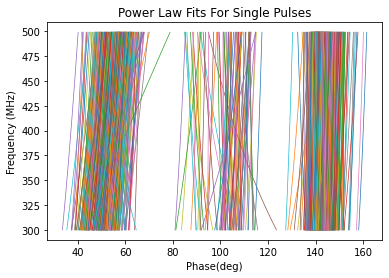

In [ ]:
#Create empty arrays to be used when calculating averages of all fits
sp_params=[]
sp_cov=[]
sp_ave=[]
#Used to ensure average points are calculated at frequency intervals of 5MHz
sp_f=list(range(300, 501, 5))
for fq in sp_f:
    sp_ave.append(pl_av(frequency=fq,phase=[]))
    
#Graph what the average components are doing
ax1,ay1=create_pl_fit(300,500,74.480,0.147)
#py.plot((np.array(ay1)-36),ax1,lw=4,color='black', label='average component movement', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
#py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=100000)    

#for a in range(3000,3100):
for a in range(0,6000):
    #Load in a pulse at a time
    pnum=str(pulse_names[a][-23:-13])
    print(a,pnum)
    single_pulse = np.loadtxt(fname=pulse_names[a], dtype=fulldatatype)
    scrunched_pulse = np.loadtxt(fname=ave_names[a], dtype=fulldatatype)
    no_freq_bands = max(single_pulse['frequency'])+1

    fit_spulse = []

    #Get expected values for the gaussian fit through fitting gaussians to the average F scrunched profile
    ax=scrunched_pulse['phase']
    ay=scrunched_pulse['intensity']
    noise = sigmaClip(ay)
    aerror = np.nanstd(noise[1])
    expect=find_expected(ax,ay,aerror)
    
    #Look at one frequency at a time
    for b in range(no_freq_bands):
        freqband = b
        f = single_pulse['frequency'] == freqband
        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]
        noise = sigmaClip(y)
        error = np.nanstd(noise[1])
        
        #Fit gaussians to each frequency channel
        if len(y)!=0:
            fit, params, sigma, cov, chir=fitting_gaussians(x,y,error,expect)
            #Find the peaks at each frequency and add to an array
            if fit!=[] and expect!=[]:
                pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500, error)
                fit_spulse.append(pulse_subp)
            

    #Find the movement of pulse across frequency and fit equations to them
    all_fits = find_fits(fit_spulse,pnum)
    
    #Manually remove pulses which have been visually tested
    #all_fits = manual_removal(a, all_fits)
    
    py.figure(1)

    #For all pulses with a fit, graph the powerlaw equation
    for v, fits in enumerate(all_fits):
        if fits!=0 and fits[1]!=0:
            #Create a continuous powerlaw fit from 300 to 500MHz -using fit parameters
            x1,y1=create_pl_fit(300,500,fits[1][0][0],fits[1][0][1])
            #Plot the power law fit
            py.plot(y1,x1, lw=0.7)
            print('Plot',v+1)
            #Add the parameters and covarience matrix to an ongoing array
            sp_params.extend(fits[1][0])
            sp_cov.append(fits[1][2])
            #For frequencies in the range of 300-500, stepping up by 5MHz,
            #Store the positions of the power law fits at each frequency 
            for i,fq in enumerate(sp_f):
                sp_ave[i][1].append(powerlaw(fq,fits[1][0][0],fits[1][0][1]))

#Set up the graphing axis and titles  
#py.legend()
py.title('Power Law Fits For Single Pulses')
py.xlabel('Phase(deg)')
py.ylabel('Frequency (MHz)')
py.savefig('figures/spulse1500.png')

No handles with labels found to put in legend.


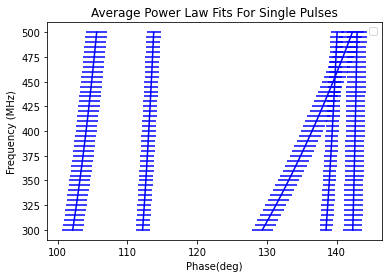

In [41]:
averages=[[] for i in range(20)]
errors=[[] for i in range(20)]
#Used to ensure average points are in phase intervals of 10 degrees
for i,n in enumerate(range(100,300,10)):
    ave_vals=[]
    cov_vals=[]
    param_vals=[]
    #Find all indicies/array positions of position values, where the position at 300MHz,
    #is in the current phase range. 
    #eg. all array entries where at 300MHz the powerlaw position is between 200-210 degrees
    indices=np.where(np.logical_and(np.array(sp_ave[0][1])>=n, np.array(sp_ave[0][1])<(n+10)))
    if len(indices[0])!=0:
        #For every value, keep track of the covarience matrix, and parameters
        for j in indices[0]:
            cov_vals.append(sp_cov[j])
            param_vals.append(sp_params[j*2])
            param_vals.append(sp_params[(j*2)+1])
        #For every frequency in steps of 5MHz, find the average of those positions - in current phase range
        for fq in range(len(sp_ave)):
            ave_vals=[sp_ave[fq][1][m] for m in np.array(indices[0])]
            averages[i].append(average(ave_vals))
        #Find the errors in all points for this phase range average, and graph the points
        errors[i]=find_y_err_pl(sp_f, param_vals, cov_vals)
        py.errorbar(averages[i],sp_f,xerr=errors[i], color='blue')

ax1,ay1=create_pl_fit(300,500,74.480,0.147)
#py.plot((np.array(ay1)-36),ax1,lw=4,color='black',label='average component movement', zorder=10)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
#py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=10)  

py.legend()
py.title('Average Power Law Fits For Single Pulses')
py.xlabel('Phase(deg)')
py.ylabel('Frequency (MHz)')
py.savefig('figures/spulse21500.png')
#py.axis([170,185,300,500])